In [16]:
# Gradient Alignment Visualiser — FigureWidget Edition (Bug‑fix)
# ==============================================================
# Fixes a TraitError raised when `layout=None` is passed into the VBox
# constructor.  We now only pass a layout when one is provided; otherwise
# we call the parent constructor with no layout argument and assign later.
# --------------------------------------------------------------
# ▸ Drop‑in replacement for previous version.
# --------------------------------------------------------------

from __future__ import annotations

import warnings
from functools import lru_cache
from pathlib import Path
from typing import Dict, Tuple, Optional

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import FloatSlider, HBox, IntSlider, Text, VBox, Layout
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------
DATA_ROOT = Path("/Users/adamsobieszek/PycharmProjects/psychGAN/content/")  # adjust to your paths
CONFIG = {
    "means": DATA_ROOT / "omi/attribute_means.csv",
    "ratings": DATA_ROOT / "omi/attribute_ratings.csv",
    "dlatents": DATA_ROOT / "coords_wlosses.csv",
}
DEFAULT_ATTRIBUTE = "trustworthy"

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------

def orthogonalize(v: np.ndarray, b: np.ndarray) -> np.ndarray:
    b_unit = b / (np.linalg.norm(b) + 1e-9)
    return v - np.dot(v, b_unit) * b_unit


@lru_cache(maxsize=16)
def load_attribute_data(attr: str):
    means_df = pd.read_csv(CONFIG["means"])
    ratings_df = pd.read_csv(CONFIG["ratings"])
    dlatents_df = pd.read_csv(CONFIG["dlatents"])

    if isinstance(dlatents_df["dlatents"].iloc[0], str):
        dlatents_df["dlatents"] = dlatents_df["dlatents"].apply(eval)

    if attr not in ratings_df.attribute.unique():
        raise ValueError(f"Attribute '{attr}' not found.")

    ratings_df = ratings_df.query("stimulus <= 1004 and attribute == @attr")
    selected = means_df.loc[means_df[attr] > 0, "stimulus"]
    ratings_df = ratings_df[ratings_df.stimulus.isin(selected)]
    dlatents_df = dlatents_df[dlatents_df.stimulus.isin(selected)]

    mean_r = ratings_df.groupby("stimulus")["rating"].mean()
    X = np.stack(dlatents_df.set_index("stimulus").loc[mean_r.index, "dlatents"].values).astype(np.float32)
    X = X-X.mean(axis=0)
    X = X/np.linalg.norm(X)
    y = (-mean_r.values).astype(np.float32)*1000

    cov = np.cov(X, rowvar=False)
    pca = PCA(min(100, X.shape[1])).fit(X)
    pc1 = pca.components_[0]
    true_grad = LinearRegression().fit(X, y).coef_
    return X, y, cov, pc1, true_grad, pca

# ------------------------------------------------------------------
# Widget class
# ------------------------------------------------------------------
class GradientAlignmentWidget(VBox):
    def __init__(
        self,
        attribute: str = DEFAULT_ATTRIBUTE,
        n_samples: int | None = None,
        lasso_alpha: float = 0.1,
        layout: Optional[Layout] = None,
    ):
        # Call parent without layout when None to avoid TraitError
        if layout is None:
            super().__init__()
        else:
            super().__init__(layout=layout)

        # Widgets ----------------------------------------------------
        self.attr_text = Text(value=attribute, description="Attribute:")
        self.n_slider = IntSlider(value=100, min=50, max=1000, step=10, description="N")
        self.alpha_slider = FloatSlider(value=lasso_alpha, min=0.001, max=1500, step=5, description="Lasso α", readout_format=".3f")

        # FigureWidget
        self.fig = go.FigureWidget(
            make_subplots(
                rows=1,
                cols=3,
                column_widths=[0.40, 0.30, 0.30],
                subplot_titles=(
                    "Gradient Alignment vs. Covariance",
                    "Whitening & Regularisation",
                    "Cosine Similarity to Top‑10 PCs",
                ),
            )
        )
        self.fig.update_layout(height=620, width=1850, showlegend=False, margin=dict(l=30, r=30, t=50, b=40))

        # Compose layout
        self.children = [HBox([self.attr_text, self.n_slider, self.alpha_slider]), self.fig]

        # Cache
        self._data: Dict[str, Tuple] = {}

        # Observe
        for w in (self.attr_text, self.n_slider, self.alpha_slider):
            w.observe(self._on_change, names="value")

        self._draw()

    # --------------------------------------------------------
    def _on_change(self, _):
        self._draw()

    # --------------------------------------------------------
    def _compute(self):
        attr = self.attr_text.value.strip()
        if attr not in self._data:
            self._data[attr] = load_attribute_data(attr)
        X, y, _cov, pc1, true_grad, pca = self._data[attr]

        self.n_slider.max = len(X)
        n = min(self.n_slider.value, len(X))
        alpha = self.alpha_slider.value

        Xn, yn = X[:n], y[:n]
        Xn = Xn*1000
        lr = LinearRegression().fit(Xn, yn)
        lr_grad = lr.coef_/np.linalg.norm(lr.coef_)*100
        lasso = Lasso(alpha=alpha*25).fit(Xn.astype(np.float64), yn.astype(np.float64))
        lasso_grad = lasso.coef_ / (np.linalg.norm(lasso.coef_) + 1e-19)*100

        ci = np.cov(Xn, rowvar=False) @ lr_grad
        ortho = orthogonalize(ci, pc1)
        return Xn/1000, yn, pc1, ortho, lr_grad, ci, lasso_grad, true_grad, pca

    # --------------------------------------------------------
    def _project(self, data, b1, b2):
        b1u = b1 / (np.linalg.norm(b1) + 1e-9)
        b2u = b2 / (np.linalg.norm(b2) + 1e-9)
        trans = np.vstack([b1u, b2u])
        d = data.reshape(1, -1) if data.ndim == 1 else data
        proj = d @ trans.T
        return proj[0] if data.ndim == 1 else proj

    # --------------------------------------------------------
    def _arrow(self, vec2d, name, color):
        if np.allclose(vec2d, 0):
            return go.Scatter(x=[], y=[])
        v = vec2d / (np.linalg.norm(vec2d) + 1e-9) * 0.8
        return go.Scatter(x=[0, v[0]], y=[0, v[1]], mode="lines+markers", marker=dict(size=[0, 5], color=color), line=dict(color=color, width=3), name=name, showlegend=True)

    # --------------------------------------------------------
    def _draw(self):
        X, y, pc1, ortho, lr_grad, ci, lasso_grad, true_grad, pca = self._compute()
        with self.fig.batch_update():
            self.fig.data = []
            self.fig.layout.shapes = ()

            # Panel 1
            X2d = self._project(X, pc1, ortho)
            self.fig.add_trace(go.Scatter(x=X2d[:,0]*100, y=X2d[:,1]*100, mode="markers", marker=dict(size=5, color=y, colorscale="Viridis", showscale=False), name="Samples"), row=1, col=1)
            for name, vec, col in [("PC1", pc1, "blue"), ("LR", lr_grad, "black"), ("CI", ci, "purple"), ("Lasso", lasso_grad, "orange")]:
                self.fig.add_trace(self._arrow(self._project(vec, pc1, ortho), name, col), row=1, col=1)
            self.fig.update_xaxes(title_text="Proj. on PC1", range=[-2,2], row=1, col=1)
            self.fig.update_yaxes(title_text="Proj. on Orthogonal", range=[-1,1],  row=1, col=1)

            # Panel 2
            for name, vec, col in [("LR", lr_grad, "black"), ("True", true_grad, "red"), ("CI", ci, "purple"), ("Lasso", lasso_grad, "orange")]:
                self.fig.add_trace(self._arrow(self._project(vec, pc1, ortho), name, col), row=1, col=2)
            self.fig.update_xaxes(range=[-1.1,1.1], row=1, col=2)
            self.fig.update_yaxes(range=[-1.1,1.1], row=1, col=2)

            # Panel 3
            pcs = pca.components_[:10]
            labels = [f"PC{i+1}" for i in range(10)]
            vecs = [pc1, lr_grad, ci, lasso_grad]
            names = ["PC1","LR","CI","Lasso"]
            sim = np.zeros((len(vecs), 10))
            for i,v in enumerate(vecs):
                vn = v / (np.linalg.norm(v)+1e-9)
                for j,pc in enumerate(pcs):
                    sim[i,j] = float(np.dot(vn, pc/ (np.linalg.norm(pc)+1e-9)))
            self.fig.add_trace(go.Heatmap(z=sim, x=labels, y=names, zmin=-1, zmax=1, colorscale="RdBu"), row=1, col=3)
            self.fig.update_xaxes(title_text="Principal Component", row=1, col=3)
            self.fig.update_yaxes(title_text="Vector", row=1, col=3)

# ------------------------------------------------------------------
# Factory function
# ------------------------------------------------------------------

def launch_gradient_alignment_widget(attr: str = DEFAULT_ATTRIBUTE):
    return GradientAlignmentWidget(attribute=attr)

launch_gradient_alignment_widget("trustworthy")

GradientAlignmentWidget(children=(HBox(children=(Text(value='trustworthy', description='Attribute:'), IntSlide…

In [17]:
# Gradient Alignment Visualiser — FigureWidget Edition (PyTorch)
# ==============================================================
# Replaces sklearn's LinearRegression and Lasso with their explicit
# matrix-form solutions for OLS and Ridge regression using PyTorch.
# --------------------------------------------------------------
# ▸ Drop‑in replacement for previous version.
# --------------------------------------------------------------

from __future__ import annotations

import warnings
from functools import lru_cache
from pathlib import Path
from typing import Dict, Tuple, Optional

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
from ipywidgets import FloatSlider, HBox, IntSlider, Text, VBox, Layout
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------
DATA_ROOT = Path("/Users/adamsobieszek/PycharmProjects/psychGAN/content/")  # adjust to your paths
CONFIG = {
    "means": DATA_ROOT / "omi/attribute_means.csv",
    "ratings": DATA_ROOT / "omi/attribute_ratings.csv",
    "dlatents": DATA_ROOT / "coords_wlosses.csv",
}
DEFAULT_ATTRIBUTE = "trustworthy"

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------

def orthogonalize(v: np.ndarray, b: np.ndarray) -> np.ndarray:
    b_unit = b / (np.linalg.norm(b) + 1e-9)
    return v - np.dot(v, b_unit) * b_unit


# @lru_cache(maxsize=16)
def load_attribute_data(attr: str):
    means_df = pd.read_csv(CONFIG["means"])
    ratings_df = pd.read_csv(CONFIG["ratings"])
    dlatents_df = pd.read_csv(CONFIG["dlatents"])

    if isinstance(dlatents_df["dlatents"].iloc[0], str):
        dlatents_df["dlatents"] = dlatents_df["dlatents"].apply(eval)

    if attr not in ratings_df.attribute.unique():
        raise ValueError(f"Attribute '{attr}' not found.")

    ratings_df = ratings_df.query("stimulus <= 1004 and attribute == @attr")
    selected = means_df.loc[means_df[attr] > 0, "stimulus"]
    ratings_df = ratings_df[ratings_df.stimulus.isin(selected)]
    dlatents_df = dlatents_df[dlatents_df.stimulus.isin(selected)]

    mean_r = ratings_df.groupby("stimulus")["rating"].mean()
    # print(mean_r)
    X = np.stack(dlatents_df.set_index("stimulus").loc[mean_r.index, "dlatents"].values).astype(np.float64)
    X = X-X.mean(axis=0)
    X = X/np.linalg.norm(X)
    y = (-mean_r.values).astype(np.float64)

    cov = np.cov(X, rowvar=False)
    pca = PCA(min(100, X.shape[1])).fit(X)
    pc1 = pca.components_[0]
    true_grad = LinearRegression().fit(X, y).coef_
    return X, y, cov, pc1, true_grad, pca

# ------------------------------------------------------------------
# Widget class
# ------------------------------------------------------------------
class GradientAlignmentWidget(VBox):
    def __init__(
        self,
        attribute: str = DEFAULT_ATTRIBUTE,
        n_samples: int | None = None,
        lasso_alpha: float = 0.1,
        layout: Optional[Layout] = None,
    ):
        # Call parent without layout when None to avoid TraitError
        if layout is None:
            super().__init__()
        else:
            super().__init__(layout=layout)

        # Widgets ----------------------------------------------------
        self.attr_text = Text(value=attribute, description="Attribute:")
        self.n_slider = IntSlider(value=100, min=50, max=1000, step=10, description="N")
        self.alpha_slider = FloatSlider(value=lasso_alpha, min=-10, max=1, step=.1, description="Ridge α", readout_format=".3f")

        # FigureWidget
        self.fig = go.FigureWidget(
            make_subplots(
                rows=1,
                cols=3,
                column_widths=[0.40, 0.30, 0.30],
                subplot_titles=(
                    "Gradient Alignment vs. Covariance",
                    "Whitening & Regularisation",
                    "Cosine Similarity to Top‑10 PCs",
                ),
            )
        )
        self.fig.update_layout(height=620, width=1850, showlegend=False, margin=dict(l=30, r=30, t=50, b=40))

        # Compose layout
        self.children = [HBox([self.attr_text, self.n_slider, self.alpha_slider]), self.fig]

        # Cache
        self._data: Dict[str, Tuple] = {}

        # Observe
        for w in (self.attr_text, self.n_slider, self.alpha_slider):
            w.observe(self._on_change, names="value")

        self._draw()

    # --------------------------------------------------------
    def _on_change(self, _):
        self._draw()

    # --------------------------------------------------------
    def _compute(self):
        attr = self.attr_text.value.strip()
        if attr not in self._data:
            self._data[attr] = load_attribute_data(attr)
        X, y, _cov, pc1, true_grad, pca = self._data[attr]

        self.n_slider.max = len(X)
        n = min(self.n_slider.value, len(X))
        alpha = self.alpha_slider.value
        alpha = np.exp(alpha)

        Xn, yn = X[:n], y[:n]
        Xn_scaled = Xn

        # --- PyTorch Implementation ---
        # Convert to PyTorch tensors
        X_t = torch.from_numpy(Xn_scaled).double()
        y_t = torch.from_numpy(yn).double().unsqueeze(1) # Ensure y is a column vector
        n_features = X_t.shape[1]
        
        # Precompute X.T @ X
        XtX = X_t.T @ X_t
        
        # 1. OLS (Linear Regression) solution: w = (X.T @ X)^-1 @ X.T @ y
        try:
            w_lr_t = torch.inverse(XtX) @ X_t.T @ y_t
            lr_grad = w_lr_t.squeeze().numpy()
            lr_grad = lr_grad / (np.linalg.norm(lr_grad) + 1e-19) * 10
        except torch.linalg.LinAlgError: # Handle singular matrix case
            lr_grad = np.zeros(n_features)

        # 2. Ridge Regression solution: w = (X.T @ X + aI)^-1 @ X.T @ y
        identity = torch.eye(n_features, dtype=torch.double)
        w_ridge_t = torch.inverse(XtX + alpha * identity) @ X_t.T @ y_t
        ridge_grad = w_ridge_t.squeeze().numpy()
        ridge_grad = ridge_grad / (np.linalg.norm(ridge_grad) + 1e-19) * 10
        # --- End PyTorch Implementation ---

        ci = np.cov(Xn_scaled, rowvar=False) @ (lr_grad / (np.linalg.norm(lr_grad) + 1e-19))
        ortho = orthogonalize(lr_grad, pc1)
        return Xn, yn, pc1, ortho, lr_grad, ci, ridge_grad, true_grad, pca

    # --------------------------------------------------------
    def _project(self, data, b1, b2):
        b1u = b1 / (np.linalg.norm(b1) + 1e-9)
        b2u = b2 / (np.linalg.norm(b2) + 1e-9)
        # rotate b1u and b2u by pi/6 degrees in the b1u-b2u plane
        rotation = np.array([[np.cos(np.pi/6), -np.sin(np.pi/6)], [np.sin(np.pi/6), np.cos(np.pi/6)]])
        b1u, b2u = rotation @ np.vstack([b1u, b2u]), rotation @ np.vstack([b1u, b2u])
        trans = np.vstack([b1u, b2u])
        d = data.reshape(1, -1) if data.ndim == 1 else data
        proj = d @ trans.T
        return proj[0] if data.ndim == 1 else proj

    # --------------------------------------------------------
    def _arrow(self, vec2d, name, color):
        if np.allclose(vec2d, 0):
            return go.Scatter(x=[], y=[])
        v = vec2d / (np.linalg.norm(vec2d) + 1e-9) * 0.8
        return go.Scatter(x=[0, v[0]], y=[0, v[1]], mode="lines+markers", marker=dict(size=[0, 5], color=color), line=dict(color=color, width=3), name=name, showlegend=True)

    # --------------------------------------------------------
    def _draw(self):
        X, y, pc1, ortho, lr_grad, ci, ridge_grad, true_grad, pca = self._compute()
        with self.fig.batch_update():
            self.fig.data = []
            self.fig.layout.shapes = ()

            # Panel 1
            X2d = self._project(X, pc1, ortho)
            self.fig.add_trace(go.Scatter(x=X2d[:,0]*100, y=X2d[:,1]*100, mode="markers", marker=dict(size=5, color=y, colorscale="Viridis", showscale=False), name="Samples"), row=1, col=1)
            for name, vec, col in [("PC1", pc1, "blue"), ("LR", lr_grad, "black"), ("CI", ci, "purple"), ("Ridge", ridge_grad, "orange")]:
                self.fig.add_trace(self._arrow(self._project(vec*2, pc1, ortho), name, col), row=1, col=1)
            self.fig.update_xaxes(title_text="Proj. on PC1", range=[-1.5,1.5], row=1, col=1)
            self.fig.update_yaxes(title_text="Proj. on Orthogonal", range=[-1.5,1.5],  row=1, col=1)

            # Panel 2
            for name, vec, col in [("LR", lr_grad, "black"), ("True", true_grad, "red"), ("CI", ci, "purple"), ("Ridge", ridge_grad, "orange")]:
                self.fig.add_trace(self._arrow(self._project(vec, pc1, ortho), name, col), row=1, col=2)
            self.fig.update_xaxes(range=[-1.1,1.1], row=1, col=2)
            self.fig.update_yaxes(range=[-1.1,1.1], row=1, col=2)

            # Panel 3
            pcs = pca.components_[:10]
            labels = [f"PC{i+1}" for i in range(10)]
            vecs = [pc1, lr_grad, ci, ridge_grad]
            names = ["PC1","LR","CI","Ridge"]
            sim = np.zeros((len(vecs), 10))
            for i,v in enumerate(vecs):
                vn = v / (np.linalg.norm(v)+1e-9)
                for j,pc in enumerate(pcs):
                    sim[i,j] = float(np.dot(vn, pc/ (np.linalg.norm(pc)+1e-9)))
            self.fig.add_trace(go.Heatmap(z=sim, x=labels, y=names, zmin=-1, zmax=1, colorscale="RdBu"), row=1, col=3)
            self.fig.update_xaxes(title_text="Principal Component", row=1, col=3)
            self.fig.update_yaxes(title_text="Vector", row=1, col=3)

# ------------------------------------------------------------------
# Factory function
# ------------------------------------------------------------------

def launch_gradient_alignment_widget(attr: str = DEFAULT_ATTRIBUTE):
    return GradientAlignmentWidget(attribute=attr)

launch_gradient_alignment_widget("trustworthy")

GradientAlignmentWidget(children=(HBox(children=(Text(value='trustworthy', description='Attribute:'), IntSlide…

In [18]:
    # ------------------------------------------------------------------
    #  Ridge-path figure (Plotly, same projection as the widget)
    #  – arrowheads via annotations, labels next to vectors
    # ------------------------------------------------------------------
    import numpy as np
    import plotly.graph_objects as go
    from sklearn.linear_model import LinearRegression

    # ---------- utilities ---------------------------------------------
    def _project(data: np.ndarray, b1: np.ndarray, b2: np.ndarray) -> np.ndarray:
        """Rotate the (b1,b2) plane by π/10 then project – matches the widget."""
        b1u = b1 / (np.linalg.norm(b1) + 1e-9)
        b2u = b2 / (np.linalg.norm(b2) + 1e-9)
        rot  = np.array([[np.cos(np.pi/15), -np.sin(np.pi/15)],
                        [np.sin(np.pi/15),  np.cos(np.pi/15)]])
        # rot = np.array([[1, 0],
        #                  [0, 1]])
        trans = rot @ np.vstack([b1u, b2u])
        d = data.reshape(1, -1) if data.ndim == 1 else data
        out = d @ trans.T
        return out[0] if data.ndim == 1 else out


    def _add_arrow(fig: go.Figure,
                vec2d: np.ndarray,
                color: str,
                label: str | None = None,
                opacity: float = 1.0):
        """
        Draw a vector from (0,0) with an arrowhead.  If `label` is given,
        place LaTeX text 5 % beyond the arrow tip.
        """
        if np.allclose(vec2d, 0):
            return
        # vec2d = vec2d / (np.linalg.norm(vec2d) + 1e-9) * 0.7

        # 1) arrow itself
        fig.add_annotation(
            x=vec2d[0], y=vec2d[1],           # arrowhead position
            ax=0, ay=0,                       # tail at origin
            xref="x", yref="y", axref="x", ayref="y",
            showarrow=True,
            arrowhead=3, arrowsize=1, arrowwidth=2,
            arrowcolor=color,
            opacity=opacity,
            text=""                           # no text here
        )

        # 2) optional label, nudged 5 % further out
        if label is not None:
            tip = vec2d * 1.05
            fig.add_annotation(
                x=tip[0], y=tip[1],
                xref="x", yref="y",
                showarrow=False,
                text="",#label,
                font=dict(size=14, color=color),
                xanchor="center", yanchor="bottom"
            )


    # ---------- main helper -------------------------------------------
    def create_ridge_alignment_plot(
        attribute: str = "trustworthy",
        n_samples: int | None = 1004,
        alphas: np.ndarray | None = None,
        n_alphas_to_show: int = 1,
        width: int = 800,
        height: int = 800,
    ):
        """
        • scatter of stimuli
        • β̂_OLS and v_CI vectors with arrowheads & on-plot LaTeX labels
        • dashed Ridge path with arrowheads for selected α
        """
        # 1 – load data & key vectors
        X, y, Σ_v, pc1, _, _ = load_attribute_data(attribute)
        #remove the max y val from X and y
        X = X[y!= y.max()]
        y = y[y!= y.max()]

        if n_samples is not None:
            X, y = X[:n_samples], y[:n_samples]


        β_ols = LinearRegression(fit_intercept=False).fit(X, y).coef_
        β_ols /= np.linalg.norm(β_ols) + 1e-12
        v_ci  = Σ_v @ β_ols
        v_ci /= np.linalg.norm(v_ci) + 1e-12

        if alphas is None:
            alphas = np.logspace(-8, 0, 1)
            
        XtX, I = X.T @ X, np.eye(X.shape[1])
        β_ridge = np.stack([np.linalg.solve(XtX + α*I, X.T @ y) for α in alphas])
        β_ridge /= np.linalg.norm(β_ridge, axis=1, keepdims=True)

        idx_show = np.linspace(len(alphas)*2//5,
                            len(alphas) - len(alphas)*2//5,
                            n_alphas_to_show//2, dtype=int)
        print(alphas)
        # 2 – projection
        ortho = orthogonalize(β_ols, pc1)
        X2d         = _project(X,        pc1, ortho) * 100
        β_ols_2d    = _project(β_ols,    pc1, ortho)*X2d[:,1].std()
        
        v_ci_2d     = _project(v_ci,     pc1, ortho)*X2d[:,0].std()#*np.linalg.norm(v_ci)
        ridge2d     = _project(β_ridge,  pc1, ortho)
        ridge2d     = ridge2d / (np.linalg.norm(ridge2d, axis=1, keepdims=True)+1e-9) * 0.7
        ridge2d_sub = ridge2d[idx_show]

        # 3 – figure
        fig = go.Figure()

        # stimuli scatter
        fig.add_trace(
            go.Scatter(
                x=X2d[:, 0], y=X2d[:, 1],
                mode="markers",
                marker=dict(size=5, color=y, colorscale="Viridis", showscale=True),
                name="Stimuli",
            )
        )

        # β̂_OLS and v_CI arrows with labels
        _add_arrow(fig, β_ols_2d, "black",  r"$\hat{\beta}_{\mathrm{OLS}}$")
        _add_arrow(fig, v_ci_2d,  "purple", r"$v_{\mathrm{CI}}$")

        # dashed Ridge path (legend entry kept)
        fig.add_trace(
            go.Scatter(
                x=ridge2d[:, 0], y=ridge2d[:, 1],
                mode="lines",
                line=dict(color="orange", dash="dash", width=2),
                name="Ridge path",
            )
        )

        # arrowheads on selected α (no legend)
        α_colors = np.linspace(0.0, 1.0, len(idx_show))
        for vec2d, frac in zip(ridge2d_sub, α_colors):
            _add_arrow(
                fig, vec2d, "orange",
                opacity=(min(frac, 1-frac)*1.5)**2
            )

        # axes & layout
        fig.update_xaxes(
            title_text=r"$\text{Projection on }\mathrm{PC}_1$",
            range=[-2, 2], zeroline=False)
        fig.update_yaxes(
            title_text=r"$\text{Projection on }\hat{\beta}_{\mathrm{OLS}}$",
            range=[-1.2, 1.3], zeroline=False)
        fig.update_layout(
            width=width, height=height,
            title=r"Ridge direction convergence to the Model CI for Trustworthiness ratings",
            legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.8)"),
            margin=dict(l=40, r=40, t=60, b=40),
        )
        return fig


    # ------------------------------------------------------------------
    # run example
    # ------------------------------------------------------------------
    if __name__ == "__main__":
        fig = create_ridge_alignment_plot()
        # Outside Jupyter this loads MathJax so LaTeX renders:
        fig.show(config={"mathjax": "cdn"})
        # fig.write_image("ridge_alignment.png", scale=3)  # needs kaleido

[1.e-08]


In [38]:
# ------------------------------------------------------------------
#  Ridge-path figure (Plotly, same projection as the widget)
#  – arrowheads via annotations, labels next to vectors
#  – vectors starting from centroid of low-rating points
#  – covariance ellipses for low and high rating groups
# ------------------------------------------------------------------
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# ---------- utilities ---------------------------------------------
def _project(data: np.ndarray, b1: np.ndarray, b2: np.ndarray) -> np.ndarray:
    """Rotate the (b1,b2) plane by π/10 then project – matches the widget."""
    b1u = b1 / (np.linalg.norm(b1) + 1e-9)
    b2u = b2 / (np.linalg.norm(b2) + 1e-9)
    rot  = np.array([[np.cos(np.pi/40), -np.sin(np.pi/40)],
                    [np.sin(np.pi/40),  np.cos(np.pi/40)]])
    # rot = np.array([[1, 0],
    #                  [0, 1]])
    trans = rot @ np.vstack([b1u, b2u])
    d = data.reshape(1, -1) if data.ndim == 1 else data
    out = d @ trans.T
    return out[0] if data.ndim == 1 else out


def _add_arrow(fig: go.Figure,
            vec2d: np.ndarray,
            color: str,
            label: str | None = None,
            opacity: float = 1.0,
            start_point: np.ndarray = None):
    """
    Draw a vector with an arrowhead.  If `label` is given,
    place LaTeX text 5 % beyond the arrow tip.
    If start_point is None, starts from (0,0).
    """
    if np.allclose(vec2d, 0):
        return
    
    # Set start point (default to origin)
    if start_point is None:
        start_point = np.array([0.0, 0.0])
    
    # Calculate arrow end point
    end_point = start_point + vec2d

    # 1) arrow itself
    fig.add_annotation(
        x=end_point[0], y=end_point[1],   # arrowhead position
        ax=start_point[0], ay=start_point[1],  # tail position
        xref="x", yref="y", axref="x", ayref="y",
        showarrow=True,
        arrowhead=3, arrowsize=1, arrowwidth=2,
        arrowcolor=color,
        opacity=opacity,
        text=""                           # no text here
    )

    # 2) optional label, nudged 5 % further out
    if label is not None:
        tip = end_point + vec2d * 0.05
        fig.add_annotation(
            x=tip[0], y=tip[1],
            xref="x", yref="y",
            showarrow=False,
            text="",#label,
            font=dict(size=14, color=color),
            xanchor="center", yanchor="bottom"
        )


def _create_ellipse_points(center, cov_matrix, n_std=2, n_points=100):
    """
    Create points for a covariance ellipse.
    
    Parameters:
    - center: 2D center point of the ellipse
    - cov_matrix: 2x2 covariance matrix
    - n_std: number of standard deviations for the ellipse size
    - n_points: number of points to create the ellipse
    
    Returns:
    - x, y coordinates of ellipse points
    """
    # Eigendecomposition of covariance matrix
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors
    order = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:, order]
    
    # Calculate angle of rotation
    angle = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])
    
    # Semi-axes lengths
    width = 2 * n_std * np.sqrt(eigenvals[0])
    height = 2 * n_std * np.sqrt(eigenvals[1])
    
    # Create ellipse in standard position
    t = np.linspace(0, 2 * np.pi, n_points)
    ellipse_x = (width / 2) * np.cos(t)
    ellipse_y = (height / 2) * np.sin(t)
    
    # Rotate ellipse
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    
    x = center[0] + ellipse_x * cos_angle - ellipse_y * sin_angle
    y = center[1] + ellipse_x * sin_angle + ellipse_y * cos_angle
    
    return x, y


def _add_covariance_ellipse(fig, points, center, color, name, n_std=2, opacity=0.3):
    """
    Add a covariance ellipse to the plot.
    
    Parameters:
    - fig: Plotly figure object
    - points: 2D array of points for the group
    - center: center point of the ellipse
    - color: color for the ellipse
    - name: name for the legend
    - n_std: number of standard deviations
    - opacity: opacity of the ellipse fill
    """
    if len(points) < 2:
        return
    
    # Calculate covariance matrix
    cov_matrix = np.cov(points.T)
    
    # Create ellipse points
    x, y = _create_ellipse_points(center, cov_matrix, n_std=n_std)
    
    # Add ellipse to plot
    def hex_to_rgb(color):
        return [int(color[i+1:i+3], 16) for i in (0, 2, 4)]
    fig.add_trace(
        go.Scatter(
            x=x, y=y,
            mode="lines",
            line=dict(color=color, width=2),
            fill="toself",
            fillcolor=f"rgba{(*[int(c*255) for c in np.array(hex_to_rgb(color))], opacity)}",
            name=name,
            showlegend=True
        )
    )


# ---------- main helper -------------------------------------------
def create_ridge_alignment_plot(
    attribute: str = "trustworthy",
    n_samples: int | None = 1004,
    alphas: np.ndarray | None = None,
    n_alphas_to_show: int = 1,
    width: int = 800,
    height: int = 800,
):
    """
    • scatter of stimuli
    • β̂_OLS and v_CI vectors with arrowheads & on-plot LaTeX labels
    • dashed Ridge path with arrowheads for selected α
    • vectors starting from centroid of low-rating points
    • centroids and connecting line shown
    • covariance ellipses for low and high rating groups
    """
    # 1 – load data & key vectors
    X, y, Σ_v, pc1, _, _ = load_attribute_data(attribute)
    #remove the max y val from X and y
    X = X[y!= y.max()]
    y = y[y!= y.max()]
    y = -y

    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]

    β_ols = -LinearRegression(fit_intercept=False).fit(X, y).coef_
    β_ols /= np.linalg.norm(β_ols) + 1e-12
    v_ci  = Σ_v @ β_ols
    v_ci /= np.linalg.norm(v_ci) + 1e-12

    
    # 2 – projection
    ortho = β_ols#orthogonalize(β_ols, pc1)
    X2d         = _project(X,        pc1, ortho) * 100
    X2d = -X2d
    β_ols_2d    = _project(β_ols,    pc1, ortho)#*np.array([0.5, 1])#*X2d[:,1].std()
    v_ci_2d     = _project(v_ci,     pc1, ortho)#*X2d[:,0].std()#*np.linalg.norm(v_ci)
    
    # 3 – calculate centroids and group masks
    low_rating_mask = y < y.mean()-y.std()
    high_rating_mask = y > y.mean()+y.std()
    print(y)
    
    low_centroid = np.mean(X2d[low_rating_mask], axis=0) if np.any(low_rating_mask) else np.array([0.0, 0.0])
    high_centroid = np.mean(X2d[high_rating_mask], axis=0) if np.any(high_rating_mask) else np.array([0.0, 0.0])
    
    # Get points for each group for covariance calculation
    low_points = X2d[low_rating_mask] if np.any(low_rating_mask) else np.array([]).reshape(0, 2)
    high_points = X2d[high_rating_mask] if np.any(high_rating_mask) else np.array([]).reshape(0, 2)

    dist_to_centroid = np.linalg.norm(high_centroid - low_centroid)
    y_dist_to_centroid = np.linalg.norm(high_centroid[1] - low_centroid[1])
    β_ols_2d = β_ols_2d * y_dist_to_centroid
    v_ci_2d = v_ci_2d * dist_to_centroid*1.2
    print(f"Distance between centroids: {dist_to_centroid}")
    print(f"Distance between centroids in y: {y_dist_to_centroid}")
    print(f"Low rating centroid (y < 70): {low_centroid}")
    print(f"High rating centroid (y > 70): {high_centroid}")
    print(f"Points with y < 70: {np.sum(low_rating_mask)}")
    print(f"Points with y > 70: {np.sum(high_rating_mask)}")

    # 4 – figure
    fig = go.Figure()

    # Add covariance ellipses first (so they appear behind other elements)
    _add_covariance_ellipse(fig, low_points, low_centroid, "#FF6B6B", "Low rating covariance", n_std=2, opacity=0.2)
    _add_covariance_ellipse(fig, high_points, high_centroid, "#4ECDC4", "High rating covariance", n_std=2, opacity=0.2)

    # stimuli scatter
    fig.add_trace(
        go.Scatter(
            x=X2d[low_rating_mask|high_rating_mask, 0], y=X2d[low_rating_mask|high_rating_mask, 1],
            mode="markers",
            marker=dict(size=8, color=y[low_rating_mask|high_rating_mask], colorscale="Viridis", showscale=True, opacity=0.6),
            name="Stimuli",
        )
    )
    # stimuli scatter
    fig.add_trace(
        go.Scatter(
            x=X2d[::, 0], y=X2d[::, 1],
            mode="markers",
            marker=dict(size=8, color=y[::], colorscale=[[0, "blue"], [1, "red"]], showscale=True, opacity=0.6),
            name="Stimuli",
        )
    )

    # Add centroids as markers
    for s, c1,c2 in [(18, 'black', 'grey'), (12, 'darkblue', 'yellow')]:
        fig.add_trace(
            go.Scatter(
                x=[low_centroid[0]], y=[low_centroid[1]],
                mode="markers",
                marker=dict(size=s, color=c1, symbol="diamond"),
                **({'name': "Low rating centroid"} if c1 == 'black' else {}),
                showlegend=False if c1 != 'black' else True,
            )
        )
    
        fig.add_trace(
            go.Scatter(
                x=[high_centroid[0]], y=[high_centroid[1]],
                mode="markers",
                marker=dict(size=s, color=c2, symbol="diamond"),
                **({'name': "High rating centroid"} if c1 == 'black' else {}),
                showlegend=False if c1 != 'black' else True,
            )
        )

    # Add line connecting centroids
    fig.add_trace(
        go.Scatter(
            x=[low_centroid[0], high_centroid[0]], 
            y=[low_centroid[1], high_centroid[1]],
            mode="lines",
            line=dict(color="black", width=3, dash="dot"),
            name="Centroid connection",
                showlegend=False

        )
    )

    # β̂_OLS and v_CI arrows with labels, starting from low centroid
    _add_arrow(fig, β_ols_2d, "black",  r"$\hat{\beta}_{\mathrm{OLS}}$", start_point=low_centroid+np.array([0, 0.07]))
    _add_arrow(fig, v_ci_2d,  "purple", r"$v_{\mathrm{CI}}$", start_point=low_centroid+np.array([0, 0.07]))



    # axes & layout
    fig.update_xaxes(
        title_text=r"$\text{Projection on }\mathrm{PC}_1$",
        range=[-2, 2], zeroline=False,
        scaleanchor="y", scaleratio=1)
    fig.update_yaxes(
        title_text=r"$\text{Projection on }\hat{\beta}_{\mathrm{OLS}}$",
        range=[-1, 1], zeroline=False,
        scaleanchor="x", scaleratio=1)
    fig.update_layout(
        width=width*2, height=height,
        title=r"Ridge direction convergence with centroids and covariance ellipses for Trustworthiness ratings",
        legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.8)"),
        margin=dict(l=40, r=40, t=60, b=40),
    )
    return fig


# ------------------------------------------------------------------
# run example
# ------------------------------------------------------------------
if __name__ == "__main__":
    fig = create_ridge_alignment_plot()
    # Outside Jupyter this loads MathJax so LaTeX renders:
    fig.show(config={"mathjax": "cdn"})
    # fig.write_image("ridge_alignment.png", scale=3)  # needs kaleido

[43.67307692 65.         37.01052632 ... 50.31818182 55.55172414
 81.20238095]
Distance between centroids: 1.0910409333374669
Distance between centroids in y: 0.3782515990504738
Low rating centroid (y < 70): [-0.51884147 -0.18590669]
High rating centroid (y > 70): [0.50453336 0.19234491]
Points with y < 70: 189
Points with y > 70: 165


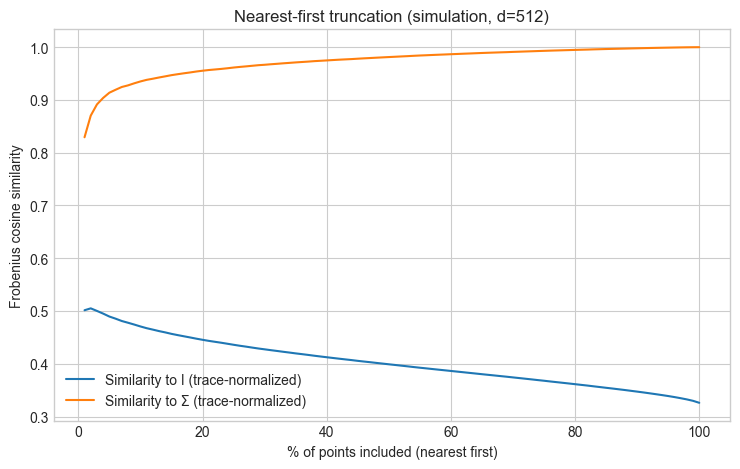

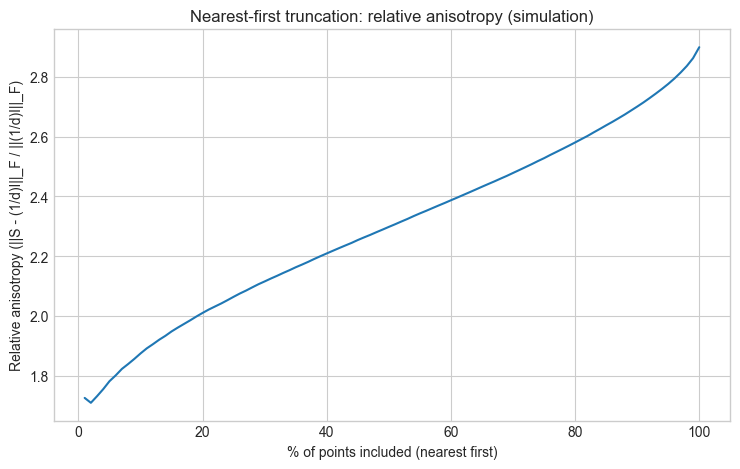

In [45]:
N = 100_000

Sigma = Σ_v
X = np.random.multivariate_normal(np.zeros(512), Sigma, N)
d=512

# Sort by Euclidean distance
r = np.linalg.norm(X, axis=1)
order = np.argsort(r)
X_sorted = X[order]

# Percent grid
percent_grid = np.linspace(1, 100, 100, endpoint=True)
ks = np.maximum(2, (percent_grid/100.0 * N).astype(int))

# Prepare arrays for cumulative Welford (per dimension)
mu = np.zeros(d, dtype=np.float64)
M2 = np.zeros(d, dtype=np.float64)  # track per-dim variance accumulators
# We'll also need cross-terms; but full covariance needs cross-dim sums.
# To keep within compute budget, we evaluate *full covariance* only at the 100 checkpoints
# by forming (X - mu) at those checkpoints; but we can compute mu incrementally to reduce work.

# Precompute Σ comparisons
def frob_sim(A, B):
    num = np.sum(A * B)
    den = np.linalg.norm(A, 'fro') * np.linalg.norm(B, 'fro')
    return float(num / den)

Sigma_unit_trace = Sigma / np.trace(Sigma)
I = np.eye(d, dtype=np.float64)
I_unit_trace = I / np.trace(I)
iso = I / d
iso_frob = np.linalg.norm(iso, 'fro')

sim_to_I = []
sim_to_Sigma = []
anisotropy_rel = []

# Walk through sorted points and compute results at checkpoints
checkpoint_set = set(ks.tolist())
current_k = 0

# To speed up covariance formation at checkpoints, we maintain cumulative sums and cross-sums
cum_sum = np.zeros(d, dtype=np.float64)
cum_xtx = np.zeros((d, d), dtype=np.float64)  # this is the heavy part but only updated per point
# We can update cum_xtx incrementally: cum_xtx += x x^T

for i in range(N):
    x = X_sorted[i, :].astype(np.float64)
    cum_sum += x
    cum_xtx += np.outer(x, x)
    current_k = i + 1

    if current_k in checkpoint_set:
        # Compute mean & covariance at this prefix
        mean = cum_sum / current_k
        # Cov = (sum xx^T - n*mu mu^T) / (n-1)
        S = (cum_xtx - current_k * np.outer(mean, mean)) / (current_k - 1)
        # Trace-normalize
        trS = np.trace(S)
        if trS <= 0:
            S_unit = iso
        else:
            S_unit = S / trS

        # Similarities
        simI = frob_sim(S_unit, I_unit_trace)
        simS = frob_sim(S_unit, Sigma_unit_trace)
        sim_to_I.append(simI)
        sim_to_Sigma.append(simS)

        # Relative anisotropy
        anisotropy_rel.append(np.linalg.norm(S_unit - iso, 'fro') / iso_frob)

# Assemble results in increasing ks order
# (Our loop adds checkpoints in increasing order already, but we sort just in case.)
pairs = sorted(zip(ks, sim_to_I, sim_to_Sigma, anisotropy_rel), key=lambda t: t[0])
ks_sorted = [p[0] for p in pairs]
sim_to_I_sorted = [p[1] for p in pairs]
sim_to_Sigma_sorted = [p[2] for p in pairs]
anisotropy_sorted = [p[3] for p in pairs]
percent_sorted = [100.0 * k / N for k in ks_sorted]

# Save data
df = pd.DataFrame({
    'percent_of_points': percent_sorted,
    'k_points': ks_sorted,
    'similarity_to_I': sim_to_I_sorted,
    'similarity_to_Sigma': sim_to_Sigma_sorted,
    'relative_anisotropy': anisotropy_sorted
})
# Plot similarities
plt.figure(figsize=(7.5, 4.8))
plt.plot(percent_sorted, sim_to_I_sorted, label='Similarity to I (trace-normalized)')
plt.plot(percent_sorted, sim_to_Sigma_sorted, label='Similarity to Σ (trace-normalized)')
plt.xlabel('% of points included (nearest first)')
plt.ylabel('Frobenius cosine similarity')
plt.title('Nearest-first truncation (simulation, d=512)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plot anisotropy
plt.figure(figsize=(7.5, 4.8))
plt.plot(percent_sorted, anisotropy_sorted)
plt.xlabel('% of points included (nearest first)')
plt.ylabel('Relative anisotropy (||S - (1/d)I||_F / ||(1/d)I||_F)')
plt.title('Nearest-first truncation: relative anisotropy (simulation)')
plt.tight_layout()
plt.show()


In [30]:
# ------------------------------------------------------------------
#  Ridge-path figure (Plotly, same projection as the widget)
#  – arrowheads via annotations, labels next to vectors
#  – vectors starting from centroid of low-rating points
#  – covariance ellipses for low and high rating groups
#  – DATA POINTS AS COLORED VECTORS FROM ORIGIN
# ------------------------------------------------------------------
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# ---------- utilities ---------------------------------------------
# def _project(data: np.ndarray, b1: np.ndarray, b2: np.ndarray) -> np.ndarray:
#     """Rotate the (b1,b2) plane by π/10 then project – matches the widget."""
#     b1u = b1 / (np.linalg.norm(b1) + 1e-9)
#     b2u = b2 / (np.linalg.norm(b2) + 1e-9)
#     rot  = np.array([[np.cos(np.pi/30), -np.sin(np.pi/30)],
#                     [np.sin(np.pi/30),  np.cos(np.pi/30)]])
#     rot = np.array([[1, 0],
#                      [0, 1]])
#     trans = rot @ np.vstack([b1u, b2u])
#     d = data.reshape(1, -1) if data.ndim == 1 else data
#     out = d @ trans.T
#     return out[0] if data.ndim == 1 else out


def _add_arrow(fig: go.Figure,
            vec2d: np.ndarray,
            color: str,
            label: str | None = None,
            opacity: float = 1.0,
            start_point: np.ndarray = None,
            arrowsize: float = 1,
            arrowwidth: float = 2):
    """
    Draw a vector with an arrowhead.  If `label` is given,
    place LaTeX text 5 % beyond the arrow tip.
    If start_point is None, starts from (0,0).
    """
    if np.allclose(vec2d, 0):
        return
    
    # Set start point (default to origin)
    if start_point is None:
        start_point = np.array([0.0, 0.0])
    
    # Calculate arrow end point
    end_point = start_point + vec2d

    # 1) arrow itself
    fig.add_annotation(
        x=end_point[0], y=end_point[1],   # arrowhead position
        ax=start_point[0], ay=start_point[1],  # tail position
        xref="x", yref="y", axref="x", ayref="y",
        showarrow=True,
        arrowhead=3, arrowsize=arrowsize, arrowwidth=arrowwidth,
        arrowcolor=color,
        opacity=opacity,
        text=""                           # no text here
    )

    # 2) optional label, nudged 5 % further out
    if label is not None:
        tip = end_point + vec2d * 0.05
        fig.add_annotation(
            x=tip[0], y=tip[1],
            xref="x", yref="y",
            showarrow=False,
            text="",#label,
            font=dict(size=14, color=color),
            xanchor="center", yanchor="bottom"
        )


def _create_ellipse_points(center, cov_matrix, n_std=2, n_points=100):
    """
    Create points for a covariance ellipse.
    
    Parameters:
    - center: 2D center point of the ellipse
    - cov_matrix: 2x2 covariance matrix
    - n_std: number of standard deviations for the ellipse size
    - n_points: number of points to create the ellipse
    
    Returns:
    - x, y coordinates of ellipse points
    """
    # Eigendecomposition of covariance matrix
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors
    order = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:, order]
    
    # Calculate angle of rotation
    angle = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])
    
    # Semi-axes lengths
    width = 2 * n_std * np.sqrt(eigenvals[0])
    height = 2 * n_std * np.sqrt(eigenvals[1])
    
    # Create ellipse in standard position
    t = np.linspace(0, 2 * np.pi, n_points)
    ellipse_x = (width / 2) * np.cos(t)
    ellipse_y = (height / 2) * np.sin(t)
    
    # Rotate ellipse
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    
    x = center[0] + ellipse_x * cos_angle - ellipse_y * sin_angle
    y = center[1] + ellipse_x * sin_angle + ellipse_y * cos_angle
    
    return x, y


def _add_covariance_ellipse(fig, points, center, color, name, n_std=2, opacity=0.3):
    """
    Add a covariance ellipse to the plot.
    
    Parameters:
    - fig: Plotly figure object
    - points: 2D array of points for the group
    - center: center point of the ellipse
    - color: color for the ellipse
    - name: name for the legend
    - n_std: number of standard deviations
    - opacity: opacity of the ellipse fill
    """
    if len(points) < 2:
        return
    
    # Calculate covariance matrix
    cov_matrix = np.cov(points.T)
    
    # Create ellipse points
    x, y = _create_ellipse_points(center, cov_matrix, n_std=n_std)
    
    # Add ellipse to plot
    def hex_to_rgb(color):
        return [int(color[i+1:i+3], 16) for i in (0, 2, 4)]
    fig.add_trace(
        go.Scatter(
            x=x, y=y,
            mode="lines",
            line=dict(color=color, width=1),
            fill="toself",
            fillcolor=f"rgba{(*[int(c*255) for c in np.array(hex_to_rgb(color))], opacity)}",
            name=name,
            showlegend=True
        )
    )


# ---------- main helper -------------------------------------------
def create_ridge_alignment_plot(
    attribute: str = "trustworthy",
    n_samples: int | None = 1004,
    alphas: np.ndarray | None = None,
    n_alphas_to_show: int = 1,
    width: int = 800,
    height: int = 800,
):
    """
    • vectors from origin to each stimulus point (colored by rating)
    • β̂_OLS and v_CI vectors with arrowheads & on-plot LaTeX labels
    • dashed Ridge path with arrowheads for selected α
    • vectors starting from centroid of low-rating points
    • centroids and connecting line shown
    • covariance ellipses for low and high rating groups
    """
    # 1 – load data & key vectors
    X, y, Σ_v, pc1, _, _ = load_attribute_data(attribute)
    #remove the max y val from X and y
    X = X[y!= y.max()]
    y = y[y!= y.max()]
    y = -y

    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]

    β_ols = -LinearRegression(fit_intercept=False).fit(X, y).coef_
    β_ols /= np.linalg.norm(β_ols) + 1e-12
    v_ci  = Σ_v @ β_ols
    v_ci /= np.linalg.norm(v_ci) + 1e-12
    # X, y = X[::6], y[::6]
    
    # 2 – projection
    ortho = β_ols#orthogonalize(β_ols, pc1)
    X2d         = _project(X,        pc1, ortho) * 100
    X2d = -X2d*np.array([0.8, 3])*1.2

    β_ols_2d    = _project(β_ols,    pc1, ortho)*np.array([0.5, 1])#*X2d[:,1].std()
    v_ci_2d     = _project(v_ci,     pc1, ortho)#*X2d[:,0].std()#*np.linalg.norm(v_ci)
    
    # 3 – calculate centroids and group masks
    low_rating_mask = (y < y.mean()-y.std()*0.8) & (X2d[:,0] < 0.8)

    high_rating_mask = y > y.mean()+y.std()*0.8 
    print(y)
    
    low_centroid = np.mean(X2d[low_rating_mask], axis=0) if np.any(low_rating_mask) else np.array([0.0, 0.0])
    high_centroid = np.mean(X2d[high_rating_mask], axis=0) if np.any(high_rating_mask) else np.array([0.0, 0.0])
    
    # Get points for each group for covariance calculation
    low_points = X2d[low_rating_mask] if np.any(low_rating_mask) else np.array([]).reshape(0, 2)
    high_points = X2d[high_rating_mask] if np.any(high_rating_mask) else np.array([]).reshape(0, 2)
    low_points = low_points[::3]
    high_points = high_points[::3]
    dist_to_centroid = np.linalg.norm(high_centroid - low_centroid)
    y_dist_to_centroid = np.linalg.norm(high_centroid[1] - low_centroid[1])
    β_ols_2d = β_ols_2d * y_dist_to_centroid
    v_ci_2d = v_ci_2d * dist_to_centroid*np.array([1.2, 1.25])*0.85
    print(f"Distance between centroids: {dist_to_centroid}")
    print(f"Distance between centroids in y: {y_dist_to_centroid}")
    print(f"Low rating centroid (y < 70): {low_centroid}")
    print(f"High rating centroid (y > 70): {high_centroid}")
    print(f"Points with y < 70: {np.sum(low_rating_mask)}")
    print(f"Points with y > 70: {np.sum(high_rating_mask)}")

    # 4 – figure
    fig = go.Figure()

    # Add covariance ellipses first (so they appear behind other elements)
    # _add_covariance_ellipse(fig, low_points, low_centroid, "#4444FF", "Low rating covariance", n_std=2, opacity=0.2)
    # _add_covariance_ellipse(fig, high_points, high_centroid, "#FF4444", "High rating covariance", n_std=2, opacity=0.2)

    # REPLACED SCATTER PLOT WITH VECTORS FROM ORIGIN
    # Add vectors for low rating points (red/orange)
    for i, point in enumerate(  low_points):
        _add_arrow(fig, point, color="#4444FF", opacity=0.9, arrowsize=2., arrowwidth=1)
    
    # Add vectors for high rating points (blue/teal)  
    for i, point in enumerate(high_points):
        _add_arrow(fig, point, color="#FF4444", opacity=0.9, arrowsize=2, arrowwidth=1)
        

    # stimuli scatter
    # fig.add_trace(
    #     go.Scatter(
    #         x=X2d[low_rating_mask|high_rating_mask, 0], y=X2d[low_rating_mask|high_rating_mask, 1],
    #         mode="markers",
    #         marker=dict(size=5, color=y[low_rating_mask|high_rating_mask], colorscale="Viridis", showscale=True, opacity=0.5),
    #         name="Stimuli",
    #     )
    # )

    # Add dummy traces for legend
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=10, color="#FF4444"),
            name="Low rating vectors",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers", 
            marker=dict(size=10, color="#4444FF"),
            name="High rating vectors",
        )
    )

    # # Add centroids as markers
    # for s, c1,c2 in [(18, 'black', 'black'), (12, 'blue', 'red')]:
    #     fig.add_trace(
    #         go.Scatter(
    #             x=[low_centroid[0]], y=[low_centroid[1]],
    #             mode="markers",
    #             marker=dict(size=s, color=c1, symbol="diamond"),
    #             **({'name': "Low rating centroid"} if c1 != 'black' else {}),
    #             showlegend=False if c1 == 'black' else True,
    #         )
    #     )
    
    #     fig.add_trace(
    #         go.Scatter(
    #             x=[high_centroid[0]], y=[high_centroid[1]],
    #             mode="markers",
    #             marker=dict(size=s, color=c2, symbol="diamond"),
    #             **({'name': "High rating centroid"} if c1 != 'black' else {}),
    #             showlegend=False if c1 == 'black' else True,
    #         )
    #     )

    # Add line connecting centroids
    # fig.add_trace(
    #     go.Scatter(
    #         x=[low_centroid[0], high_centroid[0]], 
    #         y=[low_centroid[1], high_centroid[1]],
    #         mode="lines",
    #         line=dict(color="black", width=3, dash="dot"),
    #         name="Centroid connection",
    #             showlegend=False

    #     )
    # )

    # β̂_OLS and v_CI arrows with labels, starting from low centroid
    # _add_arrow(fig, β_ols_2d, "black",  r"$\hat{\beta}_{\mathrm{OLS}}$")#, start_point=low_centroid+np.array([0, 0.07]))
    _add_arrow(fig, v_ci_2d,  "black", r"$v_{\mathrm{CI}}$", arrowsize=1.2, arrowwidth=2.5)#, start_point=low_centroid+np.array([0, 0.07]))
    df = pd.DataFrame({"x":low_points[:,0]*2, "y": low_points[:,1]*2, "color": (['blue']*len(low_points))})
    
    df = pd.concat([df, pd.DataFrame({"x":high_points[:,0]*2, "y": high_points[:,1]*2, "color": (['red']*len(high_points)), "value": (['high']*len(high_points))})])
    print(len(df))
    df.to_csv("points.csv", index=False)
    # axes & layout
    fig.update_xaxes(
        title_text=r"$\text{Projection on }\mathrm{PC}_1$",
        range=[-2, 2], zeroline=True, zerolinecolor="black", zerolinewidth=2,
        showgrid=False
    )
    fig.update_yaxes(
        title_text=r"$\text{Projection on }\hat{\beta}_{\mathrm{OLS}}$",
        range=[-2, 2], zeroline=True, zerolinecolor="black", zerolinewidth=2,
        showgrid=False
    )
    fig.update_layout(
        width=width, height=height,
        
        plot_bgcolor='white',  # White plot background
        legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.8)"),
        margin=dict(l=40, r=40, t=40, b=40),
        font=dict(size=20, color="black", family="Serif")  # Set global font to Serif
    )
    return fig


# ------------------------------------------------------------------
# run example
# ------------------------------------------------------------------
if __name__ == "__main__":
    fig = create_ridge_alignment_plot()
    # Outside Jupyter this loads MathJax so LaTeX renders:
    fig.show(config={"mathjax": "cdn"})
    # fig.write_image("ridge_alignment.png", scale=3)  # needs kaleido

[43.67307692 65.         37.01052632 ... 50.31818182 55.55172414
 81.20238095]
Distance between centroids: 1.6315379471825415
Distance between centroids in y: 1.2730302505615194
Low rating centroid (y < 70): [-0.58215477 -0.66171902]
High rating centroid (y > 70): [0.43829124 0.61131123]
Points with y < 70: 230
Points with y > 70: 238
157


In [21]:
# 1 – load data & key vectors
X, y, Σ_v, pc, _, _ = load_attribute_data("trustworthy")
print("Trace of Σ_v:", torch.trace(torch.tensor(Σ_v)))

print("First principal component (pc):",np.linalg.norm(Σ_v @ (pc)/np.linalg.norm(pc)))

Trace of Σ_v: tensor(0.0010, dtype=torch.float64)
First principal component (pc): 6.548776214501416e-05


In [28]:
# ---------- main helper -------------------------------------------
def create_ridge_alignment_plot(
    attribute: str = "trustworthy",
    n_samples: int | None = 1004,
    alphas: np.ndarray | None = None,
    n_alphas_to_show: int = 1,
    width: int = 800,
    height: int = 800,
):
    """
    • vectors from origin to each stimulus point (colored by rating)
    • β̂_OLS and v_CI vectors with arrowheads & on-plot LaTeX labels
    • dashed Ridge path with arrowheads for selected α
    • vectors starting from centroid of low-rating points
    • centroids and connecting line shown
    • covariance ellipses for low and high rating groups
    • level-set contours of β_OLS regression
    """
    # 1 – load data & key vectors
    X, y, Σ_v, pc1, _, _ = load_attribute_data(attribute)
    #remove the max y val from X and y
    X = X[y!= y.max()]
    y = y[y!= y.max()]
    y = -y

    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]

    β_ols = -LinearRegression(fit_intercept=False).fit(X, y).coef_
    β_ols /= np.linalg.norm(β_ols) + 1e-12
    v_ci  = Σ_v @ β_ols
    v_ci /= np.linalg.norm(v_ci) + 1e-12
    # X, y = X[::6], y[::6]
    
    # 2 – projection
    ortho = orthogonalize(β_ols, pc1)
    X2d         = _project(X,        pc1, ortho) * 100
    X2d = -X2d*np.array([0.8, 3])*1.2
    β_ols_2d    = _project(β_ols,    pc1, ortho)*np.array([0.5, 1])#*X2d[:,1].std()
    v_ci_2d     = _project(v_ci,     pc1, ortho)#*X2d[:,0].std()#*np.linalg.norm(v_ci)
    
    # 3 – calculate centroids and group masks
    low_rating_mask = y < y.mean()-y.std()*1.5
    high_rating_mask = y > y.mean()+y.std()*1.5
    print(y)
    
    low_centroid = np.mean(X2d[low_rating_mask], axis=0) if np.any(low_rating_mask) else np.array([0.0, 0.0])
    high_centroid = np.mean(X2d[high_rating_mask], axis=0) if np.any(high_rating_mask) else np.array([0.0, 0.0])
    
    # Get points for each group for covariance calculation
    low_points = X2d[low_rating_mask] if np.any(low_rating_mask) else np.array([]).reshape(0, 2)
    high_points = X2d[high_rating_mask] if np.any(high_rating_mask) else np.array([]).reshape(0, 2)

    dist_to_centroid = np.linalg.norm(high_centroid - low_centroid)
    y_dist_to_centroid = np.linalg.norm(high_centroid[1] - low_centroid[1])
    β_ols_2d = β_ols_2d * y_dist_to_centroid
    v_ci_2d = v_ci_2d * dist_to_centroid*np.array([1.2, 1.25])
    print(f"Distance between centroids: {dist_to_centroid}")
    print(f"Distance between centroids in y: {y_dist_to_centroid}")
    print(f"Low rating centroid (y < 70): {low_centroid}")
    print(f"High rating centroid (y > 70): {high_centroid}")
    print(f"Points with y < 70: {np.sum(low_rating_mask)}")
    print(f"Points with y > 70: {np.sum(high_rating_mask)}")

    # 4 – figure
    fig = go.Figure()

    # Add level-set contours of β_OLS regression
    x_range = np.linspace(-2, 2, 100)
    y_range = np.linspace(-1+0.2, 1.1-0.2, 100)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    
    # Calculate β_OLS dot product for each grid point
    Z_grid = β_ols_2d[0] * X_grid + β_ols_2d[1] * Y_grid
    
    fig.add_trace(
        go.Contour(
            x=x_range,
            y=y_range,
            z=Z_grid,
            showscale=False,
            line=dict(color='lightgray', width=1),
            contours=dict(
                showlines=True,
                showlabels=False,
                coloring='lines'
            ),
            name='β̂_OLS contours',
            showlegend=False,
            opacity=0.6
        )
    )

    # Add covariance ellipses first (so they appear behind other elements)
    # _add_covariance_ellipse(fig, low_points, low_centroid, "#4444FF", "Low rating covariance", n_std=2, opacity=0.2)
    # _add_covariance_ellipse(fig, high_points, high_centroid, "#FF4444", "High rating covariance", n_std=2, opacity=0.2)

    # REPLACED SCATTER PLOT WITH VECTORS FROM ORIGIN
    # Add vectors for low rating points (red/orange)
    for i, point in enumerate(X2d[low_rating_mask][::2]):
        _add_arrow(fig, point, color="#4444FF", opacity=0.9, arrowsize=2., arrowwidth=1)
    
    # Add vectors for high rating points (blue/teal)  
    for i, point in enumerate(X2d[high_rating_mask][::2]):
        _add_arrow(fig, point, color="#FF4444", opacity=0.9, arrowsize=2, arrowwidth=1)
        

    # stimuli scatter
    # fig.add_trace(
    #     go.Scatter(
    #         x=X2d[low_rating_mask|high_rating_mask, 0], y=X2d[low_rating_mask|high_rating_mask, 1],
    #         mode="markers",
    #         marker=dict(size=5, color=y[low_rating_mask|high_rating_mask], colorscale="Viridis", showscale=True, opacity=0.5),
    #         name="Stimuli",
    #     )
    # )

    # Add dummy traces for legend
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=10, color="#FF4444"),
            name="Low rating vectors",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers", 
            marker=dict(size=10, color="#4444FF"),
            name="High rating vectors",
        )
    )

    # # Add centroids as markers
    # for s, c1,c2 in [(18, 'black', 'black'), (12, 'blue', 'red')]:
    #     fig.add_trace(
    #         go.Scatter(
    #             x=[low_centroid[0]], y=[low_centroid[1]],
    #             mode="markers",
    #             marker=dict(size=s, color=c1, symbol="diamond"),
    #             **({'name': "Low rating centroid"} if c1 != 'black' else {}),
    #             showlegend=False if c1 == 'black' else True,
    #         )
    #     )
    
    #     fig.add_trace(
    #         go.Scatter(
    #             x=[high_centroid[0]], y=[high_centroid[1]],
    #             mode="markers",
    #             marker=dict(size=s, color=c2, symbol="diamond"),
    #             **({'name': "High rating centroid"} if c1 != 'black' else {}),
    #             showlegend=False if c1 == 'black' else True,
    #         )
    #     )

    # Add line connecting centroids
    # fig.add_trace(
    #     go.Scatter(
    #         x=[low_centroid[0], high_centroid[0]], 
    #         y=[low_centroid[1], high_centroid[1]],
    #         mode="lines",
    #         line=dict(color="black", width=3, dash="dot"),
    #         name="Centroid connection",
    #             showlegend=False

    #     )
    # )

    # β̂_OLS and v_CI arrows with labels, starting from low centroid
    # _add_arrow(fig, β_ols_2d, "black",  r"$\hat{\beta}_{\mathrm{OLS}}$")#, start_point=low_centroid+np.array([0, 0.07]))
    _add_arrow(fig, v_ci_2d,  "black", r"$v_{\mathrm{CI}}$", arrowsize=1.2, arrowwidth=2.5)#, start_point=low_centroid+np.array([0, 0.07]))

    # axes & layout
    fig.update_xaxes(
        title_text=r"$\text{Projection on }\mathrm{PC}_1$",
        range=[-2, 2], zeroline=True, zerolinecolor="black", zerolinewidth=2,
        showgrid=False
    )
    fig.update_yaxes(
        title_text=r"$\text{Projection on }\hat{\beta}_{\mathrm{OLS}}$",
        range=[-2, 2.], zeroline=True, zerolinecolor="black", zerolinewidth=2,
        showgrid=False
    )
    fig.update_layout(
        width=width, height=height,
        title=r"Ridge direction convergence with vector visualization for Trustworthiness ratings",

        plot_bgcolor='white',  # White plot background
        legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.8)"),
        margin=dict(l=40, r=40, t=40, b=40),
        font=dict(size=20, color="black", family="Serif")  # Set global font to Serif
    )
    

    return fig


# ------------------------------------------------------------------
# run example
# ------------------------------------------------------------------
if __name__ == "__main__":
    fig = create_ridge_alignment_plot()
    # Outside Jupyter this loads MathJax so LaTeX renders:
    fig.show(config={"mathjax": "cdn"})
    # fig.write_image("ridge_alignment.png", scale=3)  # needs kaleido

[43.67307692 65.         37.01052632 ... 50.31818182 55.55172414
 81.20238095]
Distance between centroids: 1.7362718654909635
Distance between centroids in y: 1.349492968113029
Low rating centroid (y < 70): [-0.55124235 -0.66215756]
High rating centroid (y > 70): [0.5412359 0.6873354]
Points with y < 70: 76
Points with y > 70: 70


In [23]:
# --- IMPORTS ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ipywidgets import interactive, HBox, IntSlider, Text
import warnings
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# This is a Jupyter/IPython magic command to change the current working directory.
# This is specific to your local setup to ensure the relative paths below work correctly.
%cd /Users/adamsobieszek/PycharmProjects/psychGAN/

# --- CONFIGURATION ---
CONFIG2 = {
    "data": {
        "means_path": "content/omi/attribute_means.csv",
        "ratings_path": "content/omi/attribute_ratings.csv",
        "dlatents_path": "content/coords_wlosses.csv",
        "attribute_dim": "trustworthy", # Default attribute
        "rating_scale_factor": 10.0,
        "max_ratings_per_stimulus_factor": 1.0
    }
}

# --- HELPER FUNCTION ---
def orthogonalize(vector_to_ortho, basis_vector):
    """
    Orthogonalizes a vector with respect to a basis vector using Gram-Schmidt.
    """
    basis_unit = basis_vector / (np.linalg.norm(basis_vector) + 1e-9)
    projection = np.dot(vector_to_ortho, basis_unit) * basis_unit
    orthogonal_component = vector_to_ortho - projection
    return orthogonal_component

# --- DATA PREPARATION FUNCTION ---
def prepare_data(config: dict):
    """
    Loads, filters, and prepares data from CSV files.
    Returns feature (X) and target (y) numpy arrays.
    """
    try:
        means_df = pd.read_csv(config['data']['means_path'])
        ratings_df = pd.read_csv(config['data']['ratings_path'])
        all_dlatents_df = pd.read_csv(config['data']['dlatents_path'])
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Make sure the CSV files are in the correct path.")
        return None, None

    if isinstance(all_dlatents_df["dlatents"].iloc[0], str):
        all_dlatents_df["dlatents"] = all_dlatents_df["dlatents"].apply(eval)

    dim = config['data']['attribute_dim']
    if dim not in ratings_df.attribute.unique():
        print(f"Attribute '{dim}' not found. Available: {list(ratings_df.attribute.unique())}")
        return None, None

    ratings_df = ratings_df.loc[ratings_df.stimulus <= 1004]
    ratings_df = ratings_df.loc[ratings_df.attribute == dim]
    selected_stimuli = means_df.loc[means_df[dim] > 0, 'stimulus']
    ratings_df = ratings_df[ratings_df['stimulus'].isin(selected_stimuli)]
    all_dlatents_df = all_dlatents_df[all_dlatents_df['stimulus'].isin(selected_stimuli)]

    mean_ratings = ratings_df.groupby('stimulus')['rating'].mean()
    sorted_stimuli = mean_ratings.index
    X_df = all_dlatents_df.set_index('stimulus').loc[sorted_stimuli]

    y = mean_ratings.loc[X_df.index].values
    X = np.stack(X_df['dlatents'].values)

    return X.astype(np.float32), y.astype(np.float32)

# --- CORE SIMULATION & PLOTTING CLASS ---
class GradientAlignmentSimulator:
    def __init__(self, full_X, full_y, n_samples, cov_matrix, principal_data_axis):
        # --- Store full dataset and pre-computed properties ---
        self.full_X = full_X
        self.full_y = full_y
        self.n_samples = min(n_samples, len(full_X))
        self.cov_matrix = cov_matrix
        self.principal_data_axis = principal_data_axis # PC1

        # --- Create a working subset of the data ---
        self.X = self.full_X[:self.n_samples]
        self.y = self.full_y[:self.n_samples]

        # --- Split data into quantiles ---
        self._split_data()

        # --- Fit models on the current data subset ---
        self._fit_models()

        # --- Create orthogonal basis for plotting based on the new gradient ---
        self.orthogonal_gradient_component = orthogonalize(self.logistic_gradient, self.principal_data_axis)

    def _split_data(self):
        """Splits the data into low, neutral, and high quantiles based on y."""
        low_threshold = np.percentile(self.y, 33.3)
        high_threshold = np.percentile(self.y, 66.6)
        
        self.low_mask = self.y < low_threshold
        self.high_mask = self.y > high_threshold
        
        self.X_low = self.X[self.low_mask]
        self.X_high = self.X[self.high_mask]
        
        if len(self.X_low) == 0 or len(self.X_high) == 0:
            print("Warning: Not enough data to form both low and high groups. Using dummy data.")
            self.X_low = self.X[:1] if len(self.X_low) == 0 else self.X_low
            self.X_high = self.X[-1:] if len(self.X_high) == 0 else self.X_high
            

    def _fit_models(self):
        """Fits logistic regression and computes the three key vectors."""
        # --- 1. Logistic Regression Manipulation Vector ---
        X_class = np.vstack([self.X_low, self.X_high])
        y_class = np.array([0] * len(self.X_low) + [1] * len(self.X_high))

        # Use regularization for stability, especially with small N
        logit_model = LogisticRegression(solver='liblinear', C=1000000, random_state=42).fit(X_class, y_class)
        self.logistic_gradient = logit_model.coef_[0]

        # --- 2. Classification Image from Model (cov @ beta) ---
        self.ci_from_model = self.cov_matrix @ self.logistic_gradient

        # --- 3. Classification Image from Means (mean(H) - mean(L)) ---
        self.ci_from_means = np.mean(self.X_high, axis=0) - np.mean(self.X_low, axis=0)

        # --- 4. Natural Gradient (cov^-1 @ ci) ---
        inverse_cov_matrix = np.linalg.inv(self.cov_matrix)
        self.natural_gradient = inverse_cov_matrix @ self.ci_from_means

    def project_onto_custom_basis(self, data_to_project):
        """Projects data onto the basis [PC1, Orthogonal_Gradient]."""
        v1 = self.principal_data_axis
        v2 = self.orthogonal_gradient_component
        
        v1_norm = v1 / (np.linalg.norm(v1) + 1e-9)
        v2_norm = v2 / (np.linalg.norm(v2) + 1e-9)
        
        transform_matrix = np.vstack([v1_norm, v2_norm])
        
        is_1d = data_to_project.ndim == 1
        if is_1d: data_to_project = data_to_project.reshape(1, -1)
            
        projected = data_to_project @ transform_matrix.T
        return projected[0] if is_1d else projected

    def plot_all(self):
        # Project data points for scatter plot
        X_low_2d = self.project_onto_custom_basis(self.X_low)
        X_high_2d = self.project_onto_custom_basis(self.X_high)

        fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
        plt.style.use('seaborn-v0_8-whitegrid')

        # --- Plot 1: Vector Alignment ---
        ax.scatter(X_low_2d[:, 0], X_low_2d[:, 1], c='skyblue', label='Low-Rated Group', alpha=0.7, s=30)
        ax.scatter(X_high_2d[:, 0], X_high_2d[:, 1], c='salmon', label='High-Rated Group', alpha=0.7, s=30)

        def project_and_plot_arrow(vector, color, label, style='-', zorder=5, lw=2.5, ax=ax):
            vec_2d = self.project_onto_custom_basis(vector)
            norm = np.linalg.norm(vec_2d)
            if norm < 1e-9: return
            
            xlim_range = np.abs(ax.get_xlim()[1] - ax.get_xlim()[0])
            scale_factor = (xlim_range * 0.4)
            vec_2d_scaled = vec_2d / norm * scale_factor
            
            ax.arrow(0, 0, vec_2d_scaled[0], vec_2d_scaled[1], head_width=0.03 * scale_factor,
                     head_length=0.05 * scale_factor, fc=color, ec=color,
                     linestyle=style, label=label, zorder=zorder, lw=lw)
            
            # Add text showing dot product with CI from means
            dot_product = np.dot(vector/np.linalg.norm(vector), self.ci_from_means/np.linalg.norm(self.ci_from_means))

            text_x = vec_2d_scaled[0] * 1.1
            text_y = vec_2d_scaled[1] * 1.1
            ax.text(text_x, text_y, f'{dot_product:.3f}', fontsize=8, color=color, 
                   ha='center', va='center', bbox=dict(boxstyle='round,pad=0.2', 
                   facecolor='white', alpha=0.8, edgecolor=color))

        project_and_plot_arrow(self.principal_data_axis, 'gray', '1st Principal Component', lw=1.5, style=':')
        project_and_plot_arrow(self.logistic_gradient, 'red', 'Manipulation Vector (Logistic Regression)', lw=3)
        project_and_plot_arrow(self.ci_from_model, 'purple', 'CI from Model (cov @ beta)', style='--')
        project_and_plot_arrow(self.ci_from_means, 'green', 'CI from Means (mean(H)-mean(L))', style='-.')
        project_and_plot_arrow(self.natural_gradient, 'blue', 'Natural Gradient (cov^-1 @ ci)', style='--')

        ax.set_title(f'Estimator Alignment (N={self.n_samples})', fontsize=16, pad=15)
        ax.set_xlabel('Projection on 1st Principal Component')

        ax.set_ylabel('Projection on Orthogonal Gradient Component')
        ax.legend(loc='best', fontsize='medium')
        ax.axis('equal')
        
        plt.tight_layout(pad=2.0)
        plt.show()

# --- Global cache for loaded data and computed items to avoid reloading ---
DATA_CACHE = {}

def interactive_plot_wrapper(attribute_dim, n_samples):
    if not attribute_dim: 
        print("Please enter an attribute name.")
        return
        
    cache_key = f"{attribute_dim}_base"
    if cache_key not in DATA_CACHE:
        print(f"Loading data for attribute: '{attribute_dim}'...")
        config = CONFIG2.copy()
        config['data']['attribute_dim'] = attribute_dim
        X, y = prepare_data(config)
        y = -y # Invert ratings so higher is better
        if X is None: return
            
        # pca = PCA(n_components=100).fit(X)
        # X = pca.transform(X)
        pca = PCA(n_components=1).fit(X)
        principal_data_axis = pca.components_[0]
        cov_matrix = np.cov(X, rowvar=False)

        
        DATA_CACHE[cache_key] = (X, y, cov_matrix, principal_data_axis)
    
    full_X, full_y, cov_matrix, principal_data_axis = DATA_CACHE[cache_key]
    
    n_samples_slider.max = len(full_X)
    if n_samples > len(full_X): n_samples = len(full_X)

    print(f"Running simulation with N={n_samples}")
    simulator = GradientAlignmentSimulator(full_X, full_y, n_samples, cov_matrix, principal_data_axis)
    simulator.plot_all()

# --- Create Interactive Widgets ---
attribute_input = Text(value='trustworthy', description='Attribute:', layout={'width': '300px'})
n_samples_slider = IntSlider(value=1004, min=200, max=1004, step=10, description='Num Samples (N):')

interactive_output = interactive(interactive_plot_wrapper, attribute_dim=attribute_input, n_samples=n_samples_slider)

# --- Display Widgets and Instructions ---
print("--- Interactive Simulation Controls ---")
print("Enter a valid attribute name and press Enter. Then adjust the slider.")
display(HBox([attribute_input, n_samples_slider]))
display(interactive_output.children[-1])
interactive_output.update()



/Users/adamsobieszek/PycharmProjects/psychGAN


--- Interactive Simulation Controls ---
Enter a valid attribute name and press Enter. Then adjust the slider.


Output()

In [24]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# --- 1. Load and Prepare Data ---
# The dataframe is assumed to be loaded in the notebook environment as `ratings_df`
# For example:
ratings_df = pd.read_csv(CONFIG['data']['ratings_path'])


# --- 2. Create Paired Differences ---

all_differences = []
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.min(),:]
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.max(),:]
ratings_df['rating'] = (ratings_df['rating']+0.5)/101
ratings_df['rating'] = np.log(ratings_df['rating']/(1-ratings_df['rating']))

# Group data by stimulus and attribute to create pairs within each context
grouped = ratings_df.groupby(['stimulus', 'attribute'])

for _, group_df in grouped:
    repeat_ratings = group_df[group_df['rating_type'] == 'repeat']['rating'].values
    normal_ratings = group_df[group_df['rating_type'] == 'normal']['rating'].values
    
    # Determine the number of pairs to create (the size of the smaller group)
    num_pairs = min(len(repeat_ratings), len(normal_ratings))
    
    if num_pairs > 0:
        # Shuffle both arrays to ensure random pairing
        np.random.shuffle(repeat_ratings)
        np.random.shuffle(normal_ratings)
        
        # Calculate differences for the paired ratings
        differences = repeat_ratings[:num_pairs] - normal_ratings[:num_pairs]
        all_differences.extend(differences)

# Convert to a NumPy array for statistical analysis
all_differences = np.asarray(all_differences)

print(f"Created {len(all_differences)} paired differences for analysis.\n")


# --- 3. Fit Distributions and Perform Statistical Tests ---

# Fit a Normal (Gaussian) distribution to the differences
norm_loc, norm_scale = stats.norm.fit(all_differences)
ks_stat_norm, p_value_norm = stats.kstest(all_differences, 'norm', args=(norm_loc, norm_scale))

# Fit a Logistic distribution to the differences
log_loc, log_scale = stats.logistic.fit(all_differences)
ks_stat_log, p_value_log = stats.kstest(all_differences, 'logistic', args=(log_loc, log_scale))


# --- 4. Report Statistical Results ---

print("--- Goodness of Fit Test Results ---")
print(f"Lower K-S statistic indicates a better fit.\n")
print(f"Gaussian Fit K-S Statistic: {ks_stat_norm:.4f} (p-value: {p_value_norm:.4f})")
print(f"Logistic Fit K-S Statistic: {ks_stat_log:.4f} (p-value: {p_value_log:.4f})\n")

if ks_stat_norm < ks_stat_log:
    print("Conclusion: The Gaussian (Normal) distribution appears to be a better fit for the rating differences.")
else:
    print("Conclusion: The Logistic distribution appears to be a better fit for the rating differences.")


# --- 5. Generate Visualizations ---

print("\n--- Generating Visualizations ---")
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

# Plot 1: Histogram with overlaid PDF curves
plt.subplot(1, 3, 1)
sns.histplot(all_differences, kde=False, stat='density', label='Empirical Data', color='skyblue')
x_range = np.linspace(min(all_differences), max(all_differences), 200)
plt.plot(x_range, stats.norm.pdf(x_range, norm_loc, norm_scale), 'r-', lw=2, label='Fitted Gaussian PDF')
plt.plot(x_range, stats.logistic.pdf(x_range, log_loc, log_scale), 'g--', lw=2, label='Fitted Logistic PDF')
plt.title('Distribution of Rating Differences')
plt.xlabel('Difference (Repeat - Normal)')
plt.ylabel('Density')
plt.legend()

# Plot 2: Q-Q plot for Normal fit
plt.subplot(1, 3, 2)
stats.probplot(all_differences, dist=stats.norm, sparams=(norm_loc, norm_scale), plot=plt)
plt.title('Q-Q Plot vs. Normal Distribution')

# Plot 3: Q-Q plot for Logistic fit
plt.subplot(1, 3, 3)
stats.probplot(all_differences, dist=stats.logistic, sparams=(log_loc, log_scale), plot=plt)
plt.title('Q-Q Plot vs. Logistic Distribution')

plt.tight_layout()
plt.show()



KeyError: 'data'

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

import sys
sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/')
from src.beta.mixup.interpolate import fit_beta

# --- 1. Load and Prepare Data ---
# The dataframe is assumed to be loaded in the notebook environment as `ratings_df`
# For example:
ratings_df = pd.read_csv(CONFIG['data']['ratings_path'])


# --- 2. Pre-process and Transform Ratings ---
# Remove ratings at the extreme ends of the scale
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.min(),:]
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.max(),:]
# Apply logit transformation to map [0, 100] scale to an unbounded space
ratings_df['rating_transformed'] = (ratings_df['rating']+0.5)/101
# ratings_df['rating_transformed'] = np.log(ratings_df['rating_transformed']/(1-ratings_df['rating_transformed']))


# --- 3. Per-Attribute Analysis ---
attribute_results = []
attribute_differences = {}

# Group data by attribute
grouped_by_attr = ratings_df.groupby('attribute')

for attribute, attr_df in grouped_by_attr:
    # Create paired differences for the current attribute
    repeat_ratings = attr_df[attr_df['rating_type'] == 'repeat']['rating_transformed'].values
    normal_ratings = attr_df[attr_df['rating_type'] == 'normal']['rating_transformed'].values
    
    # a_normal,b_normal = fit_beta(torch.sigmoid(torch.tensor(normal_ratings)).numpy())
    # a_repeat,b_repeat = fit_beta(torch.sigmoid(torch.tensor(repeat_ratings)).numpy())
    normal_abs = []
    repeat_abs = []
    for i in attr_df.stimulus.unique():
        normal_abs.append(fit_beta(torch.sigmoid(torch.tensor(attr_df.loc[attr_df['stimulus'] == i, 'rating_transformed'].values)).numpy()))
        repeat_abs.append(fit_beta(torch.sigmoid(torch.tensor(attr_df.loc[attr_df['stimulus'] == i, 'rating_transformed'].values)).numpy()))
    a_normal,b_normal = np.mean(normal_abs, axis=0)
    a_repeat,b_repeat = np.mean(repeat_abs, axis=0)
    
    num_pairs = min(len(repeat_ratings), len(normal_ratings))
    
    if num_pairs < 10: # Skip attributes with too few pairs for a reliable fit
        continue
    diffs = []
    for i in range(200):
        np.random.shuffle(repeat_ratings)
        np.random.shuffle(normal_ratings)
        differences = repeat_ratings[:num_pairs] - normal_ratings[:num_pairs]
        diffs.append(differences)
    differences = np.concatenate(diffs)
    differences = (differences - np.mean(differences))/np.std(differences)
    attribute_differences[attribute] = differences
    
    # Fit distributions and perform K-S tests
    norm_loc, norm_scale = stats.norm.fit(differences)
    ks_stat_norm, p_value_norm = stats.kstest(differences, 'norm', args=(norm_loc, norm_scale))
    
    log_loc, log_scale = stats.logistic.fit(differences)
    ks_stat_log, p_value_log = stats.kstest(differences, 'logistic', args=(log_loc, log_scale))
    
    # Store results
    attribute_results.append({
        'attribute': attribute,
        'ks_stat_norm': ks_stat_norm,
        'ks_stat_logistic': ks_stat_log,
        'fit_ratio': ks_stat_norm / ks_stat_log if ks_stat_log > 0 else np.inf,
        "beta_params": f"ab_normal: ({a_normal:.2f}, {b_normal:.2f}), ab_repeat: ({a_repeat:.2f}, {b_repeat:.2f})"
    })

# --- 4. Rank and Report Results ---



if attribute_results:
    results_df = pd.DataFrame(attribute_results).sort_values('fit_ratio', ascending=False).reset_index(drop=True)
    
    print("--- Analysis of Noise Distribution by Attribute ---")
    print("Attributes ranked by how much better a Logistic fit is compared to a Gaussian fit.")
    print("A 'fit_ratio' > 1.0 indicates Logistic is a better fit (lower K-S statistic).\n")
    
    num_attributes = len(results_df)
    display_n = 10
    
    if num_attributes <= display_n * 2:
        top_and_bottom_df = results_df
    else:
        top_df = results_df.head(display_n)
        bottom_df = results_df.tail(display_n)
        top_and_bottom_df = pd.concat([top_df, bottom_df])

    print(top_df.iloc[:,[0,-1,1,2,3]].to_string(index=False))
    print(bottom_df.iloc[::-1,[0,-1,1,2,3]].to_string(index=False))
    
    # --- 5. Generate Visualizations for Top and Bottom Attributes ---
    
    print("\n--- Generating Visualizations for Top and Bottom Attributes ---")
    sns.set_style("whitegrid")
    
    # for _, row in top_and_bottom_df.iterrows():
    #     attribute_to_plot = row['attribute']
    #     differences_to_plot = attribute_differences[attribute_to_plot]
        
    #     # Fit models again for plotting
    #     norm_loc, norm_scale = stats.norm.fit(differences_to_plot)
    #     log_loc, log_scale = stats.logistic.fit(differences_to_plot)
        
    #     fig = plt.figure(figsize=(18, 5))
    #     fig.suptitle(f'Noise Distribution for Attribute: "{attribute_to_plot}" (Fit Ratio: {row.fit_ratio:.2f})', fontsize=16)

    #     # Plot 1: Histogram
    #     plt.subplot(1, 3, 1)
    #     sns.histplot(differences_to_plot, kde=False, stat='density', label='Empirical Data', color='skyblue')
    #     x_range = np.linspace(min(differences_to_plot), max(differences_to_plot), 200)
    #     plt.plot(x_range, stats.norm.pdf(x_range, norm_loc, norm_scale), 'r-', lw=2, label='Fitted Gaussian')
    #     plt.plot(x_range, stats.logistic.pdf(x_range, log_loc, log_scale), 'g--', lw=2.5, label='Fitted Logistic')
    #     plt.title('Distribution of Differences')
    #     plt.xlabel('Difference (Repeat - Normal)')
    #     plt.ylabel('Density')
    #     plt.legend()

    #     # Plot 2: Q-Q plot vs. Normal
    #     plt.subplot(1, 3, 2)
    #     stats.probplot(differences_to_plot, dist=stats.norm, sparams=(norm_loc, norm_scale), plot=plt)
    #     plt.title('Q-Q Plot vs. Normal')

    #     # Plot 3: Q-Q plot vs. Logistic
    #     plt.subplot(1, 3, 3)
    #     stats.probplot(differences_to_plot, dist=stats.logistic, sparams=(log_loc, log_scale), plot=plt)
    #     plt.title('Q-Q Plot vs. Logistic')

    #     plt.tight_layout(rect=[0, 0, 1, 0.95])
    #     plt.show()

else:
    print("No attributes with sufficient data to perform analysis.")



KeyboardInterrupt: 

In [ ]:
# ------------------------------------------------------------------
#  GradientAlignmentWidget
#  ---------------------------------------------------------------
#  • Panel-1   scatter of latent samples, variance arrows
#  • Panel-2   expected MSE vs predicted-rating change Δŷ
#  • Panel-3   cosine similarity to top-10 PCs
#
#  NB: expects helper functions  load_attribute_data(...)
#                                orthogonalize(...)
#                               + plotly + ipywidgets installed
# ------------------------------------------------------------------
import numpy as np
import torch
import ipywidgets as W
from ipywidgets import VBox, HBox, Layout, Text, IntSlider, FloatSlider
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Dict, Optional, Tuple

DEFAULT_ATTRIBUTE = "trustworthy"


# ------------------------------------------------------------------
#  helpers
# ------------------------------------------------------------------
def _unit(v: np.ndarray) -> np.ndarray:
    return v / (np.linalg.norm(v) + 1e-19)


def _risk_vs_dy(
    direction_v: np.ndarray,
    beta_hat: np.ndarray,
    Sigma: np.ndarray,
    mse0: float,
    X: np.ndarray,
    dy_grid: np.ndarray,
    beta_true: Optional[np.ndarray] = None,
) -> np.ndarray:
    """
    Calculates the expected RMSE vs. Δŷ, where the manipulation 'slope'
    is determined by the variance of the data along the manipulation direction.
    
    RMSE(Δŷ) = sqrt( mse0 + B ⋅ Δŷ² )
    
    where B = ( vᵀΣv + κ² ) / Var(Xv)²
    """
    # The "effective slope" is the variance of the projected data.
    effective_slope = np.var(X @ direction_v)

    if effective_slope < 1e-12:
        return np.full_like(dy_grid, np.sqrt(mse0))

    # Parameter variance contribution
    var_term = direction_v @ Sigma @ direction_v

    # Bias contribution (squared)
    bias_sq_term = 0.0
    if beta_true is not None:
        # κ is the projection of the estimation error onto the direction of travel
        kappa = (beta_hat - beta_true) @ direction_v
        bias_sq_term = kappa**2

    # Total quadratic coefficient B
    B = (var_term + bias_sq_term) / (effective_slope**2)

    return np.sqrt(mse0 + B * dy_grid**2)


# ------------------------------------------------------------------
#  main widget
# ------------------------------------------------------------------
class GradientAlignmentWidget(VBox):
    def __init__(
        self,
        attribute: str = DEFAULT_ATTRIBUTE,
        n_samples: Optional[int] = None,
        lasso_alpha: float = 0.1,
        layout: Optional[Layout] = None,
    ):
        if layout is None:
            layout = Layout()
        super().__init__(layout=layout)

        # widgets ---------------------------------------------------
        self.attr_text   = Text(value=attribute, description="Attribute:")
        self.n_slider    = IntSlider(
            value=100, min=100, max=1000, step=10, description="N"
        )
        self.alpha_slider = FloatSlider(
            value=lasso_alpha,
            min=-10, max=1, step=.1,
            description="Ridge α",
            readout_format=".3f"
        )

        # figure ----------------------------------------------------
        self.fig = go.FigureWidget(
            make_subplots(
                rows=1, cols=3,
                column_widths=[0.40, 0.30, 0.30],
                subplot_titles=(
                    "Gradient Alignment vs Covariance",
                    "Expected RMSE vs Δŷ",
                    "Cosine Similarity to Top-10 PCs",
                ),
            )
        )
        self.fig.update_layout(
            height=620, width=1850, showlegend=True,
            margin=dict(l=30, r=30, t=50, b=40)
        )

        # assemble --------------------------------------------------
        self.children = [
            HBox([self.attr_text, self.n_slider, self.alpha_slider]),
            self.fig,
        ]

        # cache & observers
        self._data: Dict[str, Tuple] = {}
        
        for w in (self.attr_text, self.n_slider, self.alpha_slider):
            w.observe(self._on_change, names="value")

        self._draw()

    # ----------------------------------------------------------
    # internal callbacks
    # ----------------------------------------------------------
    def _on_change(self, _):
        self._draw()

    # ----------------------------------------------------------
    # heavy compute block (fits OLS & Ridge once per redraw)
    # ----------------------------------------------------------
    def _compute(self):
        attr = self.attr_text.value.strip()
        if attr not in self._data:
            self._data[attr] = load_attribute_data(attr)
        
        X, y, _cov, pc1, true_grad, pca = self._data[attr]
        self.n_slider.max = len(X)
        n      = min(self.n_slider.value, len(X))
        alpha  = np.exp(self.alpha_slider.value)

        Xn, yn = X[:n], y[:n]
        X_t    = torch.from_numpy(Xn).double()
        y_t    = torch.from_numpy(yn).double().unsqueeze(1)
        y_t = y_t - y_t.mean() # Center the target variable

        self.XtX = X_t.T @ X_t
        n_feat   = X_t.shape[1]

        # ---------- OLS ---------------------------------------
        try:
            self.w_lr_t = torch.inverse(self.XtX) @ X_t.T @ y_t
            lr_grad = self.w_lr_t.squeeze().numpy()
        except torch.linalg.LinAlgError:
            self.w_lr_t = torch.zeros(n_feat, 1)
            lr_grad = np.zeros(n_feat)

        # ---------- Ridge -------------------------------------
        I = torch.eye(n_feat, dtype=torch.double)
        w_ridge_t = torch.inverse(self.XtX + alpha * I) @ X_t.T @ y_t
        ridge_grad = w_ridge_t.squeeze().numpy()

        # ---------- CI  = Σ · β̂ ------------------------------
        ci = np.cov(Xn, rowvar=False) @ _unit(lr_grad)

        ortho = orthogonalize(lr_grad, pc1)

        return Xn, yn, pc1, ortho, lr_grad, ci, ridge_grad, true_grad, pca

    # ----------------------------------------------------------
    # 2D projection helper
    # ----------------------------------------------------------
    def _project(self, data, b1, b2):
        b1u, b2u = _unit(b1), _unit(b2)
        rot = np.array(
            [[np.cos(np.pi / 6), -np.sin(np.pi / 6)],
             [np.sin(np.pi / 6),  np.cos(np.pi / 6)]]
        )
        b1r, b2r = (rot @ np.vstack([b1u, b2u]))
        trans = np.vstack([b1r, b2r])
        d = data.reshape(1, -1) if data.ndim == 1 else data
        proj = d @ trans.T
        return proj[0] if data.ndim == 1 else proj

    # arrow helper
    def _arrow(self, vec2d, name, color):
        if np.allclose(vec2d, 0):
            return go.Scatter(x=[], y=[])
        v = _unit(vec2d) * 0.8
        return go.Scatter(
            x=[0, v[0]], y=[0, v[1]],
            mode="lines+markers",
            marker=dict(size=[0, 5], color=color),
            line=dict(color=color, width=3),
            name=name, showlegend=True,
        )

    # ----------------------------------------------------------
    # main draw
    # ----------------------------------------------------------
    def _draw(self):
        (X, y, pc1, ortho,
         lr_grad, ci, ridge_grad, true_grad, pca) = self._compute()
        y = (y-y.mean())/np.std(y)
        # -------------------------------------------------- panel-1
        # (Panel 1 code is unchanged)
        X2d = self._project(X, pc1, ortho)
        self.fig.data = []                  # clear
        self.fig.add_trace(go.Scatter(x=X2d[:, 0] * 100, y=X2d[:, 1] * 100, mode="markers", marker=dict(size=5, color=y, colorscale="Viridis", showscale=False), name="Samples"), row=1, col=1)
        for name, vec, col in [("PC1", pc1, "blue"), ("LR", lr_grad, "black"), ("CI", ci, "purple"), ("Ridge", ridge_grad, "orange")]:
            vec_scaled = _unit(vec) * 10 
            self.fig.add_trace(self._arrow(self._project(vec_scaled * 2, pc1, ortho), name, col), row=1, col=1)
        self.fig.update_xaxes(title_text="Proj. on PC1", range=[-1.5, 1.5], row=1, col=1)
        self.fig.update_yaxes(title_text="Proj. on Orthogonal", range=[-1.5, 1.5], row=1, col=1)
        annotations = []
        v_dict = {"PC1":  (pc1,  "blue", (0.02, 0.98)), "LR":   (lr_grad, "black", (0.98, 0.98)), "CI":   (ci,   "purple", (0.02, 0.02)), "Ridge":(ridge_grad,"orange",(0.98, 0.02))}
        for name, (vec, color, pos) in v_dict.items():
            if np.linalg.norm(vec) < 1e-9: continue
            variance = np.var(X @ _unit(vec)) * 1e6
            annotations.append(go.layout.Annotation(text=f"Var ({name}): <b>{variance:.3f}</b>", showarrow=False, xref="x domain", yref="y domain", x=pos[0], y=pos[1], xanchor="left" if pos[0] < 0.5 else "right", yanchor="bottom" if pos[1] < 0.5 else "top", font=dict(color=color, size=14), bgcolor="rgba(255,255,255,0.7)"))
        self.fig.layout.annotations = tuple(annotations)

        # -------------------------------------------------- panel-2 (REWRITTEN)
        # Normalize directions for risk calculation
        lr_v = _unit(lr_grad)
        ridge_v = _unit(ridge_grad)
        ci_v = _unit(ci)
        
        # Residual noise (initial MSE)
        y_pred_lr = X @ self.w_lr_t.numpy()
        sigma2_hat_lr = np.var(y - y_pred_lr, ddof=X.shape[1] + 1)

        # Σ_β for OLS
        try:
            XtX_inv = np.linalg.inv(self.XtX)
            Sigma_ols = sigma2_hat_lr * XtX_inv
        except np.linalg.LinAlgError:
            Sigma_ols = np.zeros((X.shape[1], X.shape[1]))

        # Σ_β for Ridge
        alpha_val = np.exp(self.alpha_slider.value)
        XtX_alpha = self.XtX + alpha_val * torch.eye(X.shape[1], dtype=torch.double)
        try:
            XtX_alpha_inv = np.linalg.inv(XtX_alpha.numpy())
            Sigma_ridge = (sigma2_hat_lr * XtX_alpha_inv @ self.XtX.numpy() @ XtX_alpha_inv)
        except np.linalg.LinAlgError:
            Sigma_ridge = np.zeros((X.shape[1], X.shape[1]))

        # Set Δŷ grid based on the maximum data variance along any direction
        max_var = max(np.var(X @ lr_v), np.var(X @ ridge_v), np.var(X @ ci_v))
        dy_grid = np.linspace(0.0, np.sqrt(max_var), 100)
        
        # Calculate risk curves using the new logic
        curves = {
            "OLS β":   _risk_vs_dy(lr_v, lr_grad, Sigma_ols, sigma2_hat_lr, X, dy_grid, beta_true=true_grad),
            "Ridge β": _risk_vs_dy(ridge_v, ridge_grad, Sigma_ridge, sigma2_hat_lr, X, dy_grid, beta_true=true_grad),
            "Σ·β":     _risk_vs_dy(ci_v, ci, Sigma_ols, sigma2_hat_lr, X, dy_grid),
        }

        # Plot the results
        keep = [tr for tr in self.fig.data if tr.xaxis != "x2"]
        self.fig.data = tuple(keep)
        for name, curve in curves.items():
            self.fig.add_trace(go.Scatter(x=dy_grid, y=curve, mode="lines", name=name, showlegend=True), row=1, col=2)
        
        self.fig.update_xaxes(title_text="Predicted rating change Δŷ", range=[0, dy_grid.max()], row=1, col=2)
        self.fig.update_yaxes(title_text="Expected RMSE  R(Δŷ)", row=1, col=2)

        # -------------------------------------------------- panel-3
        # (Panel 3 code is unchanged)
        pcs = pca.components_[:10]
        labels = [f"PC{i+1}" for i in range(10)]
        vecs = [pc1, lr_grad, ci, ridge_grad]
        names = ["PC1", "LR", "CI", "Ridge"]
        sim = np.zeros((len(vecs), 10))
        for i, v in enumerate(vecs):
            vn = _unit(v)
            for j, pc in enumerate(pcs):
                sim[i, j] = float(np.dot(vn, _unit(pc)))
        keep = [tr for tr in self.fig.data if tr.xaxis != "x3"]
        self.fig.data = tuple(keep)
        self.fig.add_trace(go.Heatmap(z=sim, x=labels, y=names, zmin=-1, zmax=1, colorscale="RdBu"), row=1, col=3)
        self.fig.update_xaxes(title_text="Principal Component", row=1, col=3)
        self.fig.update_yaxes(title_text="Vector", row=1, col=3)
# ------------------------------------------------------------------
# convenience factory
# ------------------------------------------------------------------
def launch_gradient_alignment_widget(attr: str = DEFAULT_ATTRIBUTE):
    return GradientAlignmentWidget(attribute=attr)


launch_gradient_alignment_widget("trustworthy")

KeyError: 'means'

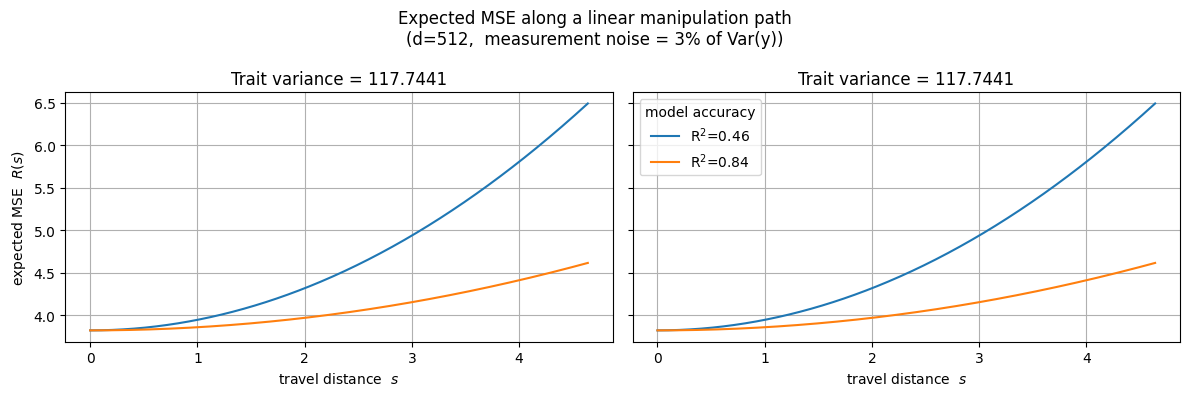

In [ ]:
"""
Risk-curve generator for linear manipulation paths
==================================================

Given:
  • a *ground-truth* linear impression model  f_y(x) = β⋅x + c
  • a linear *estimator*   β̂  whose out-of-sample R² is preset,
this script plots the expected mean-squared prediction error

        R(s) = E[(β̂⋅x_s + ĉ  −  β⋅x_s − c)²]

after travelling a distance  s  along the *unit* manipulation
direction v = β̂ / ‖β̂‖.

Assumptions
-----------
* Latent codes  x ~ N(0, I_d)  (isotropic unit covariance)
* Estimation noise  β̂ = β + η,     η ~ N(0, τ² I_d)
  –>  closed-form link   τ² = (1 − R²) · ‖β‖² / d
* Intercept variance ignored (or absorb into the constant term)
* Optional measurement noise  ξ  with variance  σ²_ε

Outputs
-------
One plot per ground-truth trait variance, with multiple risk curves
corresponding to different desired accuracies (R²).
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

# ----------------------- configuration ------------------------ #
d               = 512                            # latent dimensionality
trait_variances = [10.0, 25.0]                    # Var(y) for two traits
target_R2       = [0.6, 0.8, 0.95]      # accuracies to compare
sigma_eps_frac  = 0.05                          # meas-noise as % of Var(y)
s_max, n_points = 10.0, 250                     # path-length grid
rng             = np.random.default_rng(42)     # reproducibility
# -------------------------------------------------------------- #

trait_variances = [117.7441]*2
target_R2       = [0.46179813146591187, 0.84]
sigma_eps_frac  = 38/117 /10 #(mean of individual fractions)
s_max, n_points = 4.64, 500
def draw_beta(var_y, dim, rng):
    """Sample β such that  Var(β⋅x) = var_y  when  x~N(0,I)."""
    b = rng.normal(size=dim)
    return b * np.sqrt(var_y) / norm(b)

def tau_from_R2(beta, R2):
    """Isotropic parameter noise τ given desired R²."""
    if R2 >= 1.0:          # perfect predictor
        return 0.0
    return np.sqrt((1.0 - R2) * norm(beta) ** 2 / d)

def risk_curve(s, tau2, sigma_eps2):
    """R(s) for unbiased β̂ with isotropic Σβ = τ² I_d."""
    return tau2 * s**2 + sigma_eps2

# travel-distance grid
s_grid = np.linspace(0.0, s_max, n_points)

fig, axes = plt.subplots(
    1, len(trait_variances), figsize=(12, 4), sharey=True
)

for ax, var_y in zip(axes, trait_variances):
    beta         = draw_beta(var_y, d, rng)
    sigma_eps2   = var_y * sigma_eps_frac

    for R2 in target_R2:
        tau2  = tau_from_R2(beta, R2) ** 2
        curve = risk_curve(s_grid, tau2, sigma_eps2)
        ax.plot(s_grid, curve, label=f"R$^2$={R2:.2f}")

    ax.set_title(f"Trait variance = {var_y}")
    ax.set_xlabel("travel distance  $s$")
    ax.grid(True)

axes[0].set_ylabel("expected MSE  $R(s)$")
axes[-1].legend(title="model accuracy")
fig.suptitle(
    "Expected MSE along a linear manipulation path\n"
    f"(d={d},  measurement noise = {sigma_eps_frac*100:.0f}% of Var(y))"
)
plt.tight_layout()
plt.show()

In [ ]:
"""
Risk-Curve Generator for Linear Manipulation Paths (Variance-Only)
==================================================================

Given:
  • A dataset (X, y) loaded via a helper function.
  • A set of linear estimators (OLS, Ridge) fit to the data.

This script plots the expected mean-squared error arising from
parameter variance and irreducible noise:

        R(s) ≈ s²(vᵀΣ_β̂v) + σ_ξ²

after travelling a distance s along each estimator's manipulation
direction v = β̂ / ‖β̂‖. This analysis assumes the estimator is
unbiased, as the true bias is unknown.
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
import sys
sys.path.append("/Users/adamsobieszek/PycharmProjects/_manipy")
from manipy.stylegan.utils import sample_w

# This script assumes your helper functions are available.
# from your_project import load_attribute_data

# ----------------------- Configuration ------------------------ #
attribute = "trustworthy"
# Compare OLS (alpha=0) with Ridge regression at different strengths
alphas = [0, 0.1, 0.2, 1.0, 2.0]
# Path-length grid for the x-axis
S_MAX, N_POINTS = 5.0, 200
# -------------------------------------------------------------- #

import pickle
psychGAN_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/"
with open(psychGAN_path+"photo_to_coords.pkl", "rb") as f:
    photo_to_coords = pickle.load(f)
with open(psychGAN_path+"dim_to_photo_to_ratings.pkl", "rb") as f:
    dim_to_photo_to_ratings = pickle.load(f)

def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))


def prepare_data2(config: dict, verbose=False):
    if isinstance(config, str):
        config = {"data": {"attribute_dim": config}}
    xs, ys = photo_to_coords, dim_to_photo_to_ratings[config['data']['attribute_dim']]
    imgs = set(ys.keys()).intersection(set(xs.keys()))-set('638.jpg')
    X = torch.stack([xs[k] for k in imgs]).to('mps', torch.float32)
    # X = X - G.mapping.w_avg.reshape(1,-1)  #X.mean(dim=0)
    # X = X / X.std()
    max_len = int(max(len(ys[k]) for k in imgs) * config['data'].get('rating_oversampling_factor', 1.0))
    y = torch.tensor([pad_list(ys[k], max_len) for k in imgs], device='mps', dtype=torch.float32)
    n = y.shape[1] - y.isnan().sum(dim=1)
    sample_size_weights = (n.reshape(-1)) 
    sample_size_weights = sample_size_weights / sample_size_weights.sum()*len(n)
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel='gaussian', bandwidth=.5).fit(torch.nanmean(y, dim=1).cpu().numpy().reshape(-1,1))
    log_dens = kde.score_samples(torch.nanmean(y, dim=1).cpu().numpy().reshape(-1,1))
    weights = (np.exp(-log_dens))
    weights = torch.tensor(weights/np.sum(weights)*len(n), device='mps', dtype=torch.float32)

    # pressure = torch.sigmoid(torch.nanmean(y, dim=1, keepdim=True))*(1-torch.sigmoid(torch.nanmean(y, dim=1, keepdim=True)))
    # pressure = pressure / pressure.sum()*len(n)
    # weights = sample_size_weights*pressure
    # weights = weights**2
    # weights = weights / weights.sum()*len(n)
    return X, torch.nanmean(y, dim=1, keepdim=True), weights


def load_attribute_data(attr: str):
    means_df = pd.read_csv(CONFIG["means"])
    ratings_df = pd.read_csv(CONFIG["ratings"])
    dlatents_df = pd.read_csv(CONFIG["dlatents"])

    if isinstance(dlatents_df["dlatents"].iloc[0], str):
        dlatents_df["dlatents"] = dlatents_df["dlatents"].apply(eval)

    if attr not in ratings_df.attribute.unique():
        raise ValueError(f"Attribute '{attr}' not found.")

    ratings_df = ratings_df.query("stimulus <= 1004 and attribute == @attr")
    selected = means_df.loc[means_df[attr] > 0, "stimulus"]
    ratings_df = ratings_df[ratings_df.stimulus.isin(selected)]
    dlatents_df = dlatents_df[dlatents_df.stimulus.isin(selected)]

    mean_r = ratings_df.groupby("stimulus")["rating"].mean()
    X = np.stack(dlatents_df.set_index("stimulus").loc[mean_r.index, "dlatents"].values).astype(np.float64)
    X = X-X.mean(axis=0)
    # X = X/np.linalg.norm(X)
    y = (mean_r.values).astype(np.float64)
    
    cov = np.cov(X, rowvar=False)
    pca = PCA(min(100, X.shape[1])).fit(X)
    pc1 = pca.components_[0]
    true_grad = LinearRegression().fit(X, y).coef_
    return X, y, cov, pc1, true_grad, pca


def fit_estimator(X_t, y_t, XtX, alpha=0.0):
    """Fits a Ridge (or OLS) estimator and returns its coefficients."""
    n_feat = X_t.shape[1]
    I = torch.eye(n_feat, dtype=torch.double)
    
    try:
        # Ridge: β̂ = (XᵀX + αI)⁻¹Xᵀy
        w_t = torch.inverse(XtX + alpha * I) @ X_t.T @ y_t
        return w_t.squeeze().numpy()
    except torch.linalg.LinAlgError:
        return np.zeros(n_feat)

def calculate_variance_risk_curve(s_grid, beta_hat, Sigma_beta, sigma_eps2):
    """
    Calculates the variance-based risk curve R(s) for a given estimator,
    assuming the bias is zero (or unknown).
    R(s) = s²(vᵀΣ_β̂v) + σ_ξ²
    """
    if norm(beta_hat) < 1e-9:
        return np.full_like(s_grid, sigma_eps2)

    v = beta_hat / norm(beta_hat)
    
    # Variance component: vᵀΣ_β̂v
    param_variance = v @ Sigma_beta @ v
    
    # Risk curve (only parameter variance + irreducible noise)
    return param_variance * (s_grid)**2 + sigma_eps2


# def generate_risk_plot_for_attribute(attribute: str, alphas: list):
# """Loads data for an attribute and generates its risk curve plot."""

# 1. Load Data
try:
    # Unpacking is changed to ignore the mislabeled ground-truth variable
    # X, y, _, _, _, _ = load_attribute_data(attribute)
    # X_t = torch.from_numpy(X).double()
    # y_t = torch.from_numpy(y).double().unsqueeze(1)
    X_t, y_t, _ = prepare_data2("trustworthy")
    X_t = X_t - G.mapping.w_avg.reshape(1,-1)  #X.mean(dim=0)
    X_t = X_t.cpu().double()
    y_t = y_t.cpu().double()*100
    y_t = y_t-y_t.mean()
    y = y_t.cpu().numpy()
    X = X_t.cpu().numpy()
    # PCA transform
    # pca = PCA(min(100, X.shape[1])).fit(X)
    # X = pca.transform(X)
    # X_t = torch.from_numpy(X).double()
    # print(X_t[0].norm())
except NameError:
    print("ERROR: `load_attribute_data` is not defined.")
    print("Please ensure this script can access your helper functions.")

n, d = X.shape

X_all = sample_w(30_000, truncation_psi=1, _G=G)
XtX_theoretical = (X_all.T @ X_all).cpu().numpy()/30_000*n
XtX_sample = (X_t.T @ X_t)
XtX_theoretical = XtX_sample.cpu().numpy()


S_MAX = (y_t.max() - y_t.min())/3
# Travel-distance grid
s_grid = np.linspace(0, S_MAX, N_POINTS)

# --- Plotting Setup ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Loop through estimators (different alphas)
for alpha in alphas:
    # Fit the estimator
    beta_hat = fit_estimator(X_t, y_t, XtX_sample, alpha)

    # Calculate residual noise for this estimator
    y_pred = X @ beta_hat.reshape(-1,1)
    residuals = y - y_pred
    print(residuals)
    sigma_eps2 = np.var(residuals)
    # S_MAX = ((X @ beta_hat.reshape(-1,1)/np.linalg.norm(beta_hat)).max())/3
    S_MAX = 30
    # Travel-distance grid
    s_grid = np.linspace(0, S_MAX, N_POINTS)

    # Calculate the estimator's covariance matrix Σ_β̂
    # For Ridge: σ_ξ²(XᵀX + αI)⁻¹(XᵀX)(XᵀX + αI)⁻¹
    I_np = np.eye(d)
    try:
        # Use XtX_theoretical for the covariance calculation
        inv_term = np.linalg.inv(XtX_theoretical + alpha * I_np)
        Sigma_beta = sigma_eps2 * (inv_term @ XtX_theoretical @ inv_term)
    except np.linalg.LinAlgError:
        Sigma_beta = np.zeros((d, d))
    # 3. Calculate the risk curve for this estimator
    curve = calculate_variance_risk_curve(s_grid/np.linalg.norm(beta_hat)**2, beta_hat, Sigma_beta, sigma_eps2)
    
    # 4. Plot the curve
    label = "OLS" if alpha == 0 else f"Ridge (α={alpha})"
    ax.plot(s_grid, curve, label=label)

# --- Finalize Plot ---
ax.set_title(f"Parameter-Variance Risk for '{attribute.capitalize()}' Trait (d={d})", fontsize=16)
ax.set_xlabel("Travel Distance  $s$", fontsize=12)
ax.set_ylabel("Expected MSE from Variance  $R_{var}(s)$", fontsize=12)
ax.legend(title="Estimator")
# ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.tight_layout()
plt.show()

# if __name__ == '__main__':
#     # To run this script, you must have the `load_attribute_data` function
#     # available in the environment.
#     # For example: from your_project import load_attribute_data
#     generate_risk_plot_for_attribute(ATTRIBUTE_TO_PLOT, ALPHAS)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print("MSE:", mse)

In [ ]:
import pickle
device = 'mps'
sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)